In [ ]:
# Jovian Commit Essentials
# Please retain and execute this cell without modifying the contents for `jovian.commit` to work
!pip install jovian --upgrade -q
import jovian
jovian.set_project('post-analysis-models-implementation-and-evaluation')
jovian.set_colab_id('1S5oLvfk-N4sA7k4gYLe4SzT6XPI7HOwV')

<a id='top'></a>
## Table of Contents
1. [Data Understanding and Project Proposal](#dupp)
2. [Models Implementation and Evaluation](#mie)
    1. [Movie Profitability Regression](#reg)
        1. [Additional Features Engineering](#afer)
        2. [Regressors](#regs)
        3. [Experiments](#expr)
        4. [Testcases](#tcr)
    2. [Movie Profitability Classification](#clf)
        1. [Additional Features Engineering](#afec)
        2. [Handling Unbalanced Data](#hud)
        3. [Classifiers](#clfs)
        4. [Experiments](#expc)
        5. [Testcases](#tcc)
3. [Conclusion](#conc)

<a id='dupp'></a>
# 1. Data Understanding and Project Proposal ([to top](#top))
https://jovian.ai/lilanpei/data-understanding-and-project-proposal

Although We have already performed extensive analysis of our data and haven't done a lot with respect to determining factors that make a movie a success. We all know how the economic return a producer can get from a film is important. So what factors influence whether a movie will be able to recoup its investments? To answer this question, we shall attempt to build :

* A **Regressor** that can, to a certain degree, predict the economic return of a particular movie starting from its characteristics.
* A **Classifier** that identifies if a movie will be a hit or will make the producers lose money.

<a id='mie'></a>
# 2. Models Implementation and Evaluation ([to top](#top))

<a id='reg'></a>
## A. Movie Profitability Regression ([to top](#top))

<a id='afer'></a>
### 1). Additional Features Engineering([to top](#top))

Install necessary libraries :

In [ ]:
try:
    import autosklearn.regression
    import autosklearn.classification
    import gdown
    from imblearn.over_sampling import SMOTE
except ModuleNotFoundError: 
    !pip3 install auto-sklearn
    !pip3 install gdown
    !pip3 install -U git+https://github.com/scikit-learn-contrib/imbalanced-learn.git
    
    # Kill the current Python runtime process
    import os
    os.kill(os.getpid(), 9)

**Note:** The auto-sklearn installation ask to **restart the runtime**:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%matplotlib inline
import autosklearn.regression
import autosklearn.classification
from imblearn.over_sampling import SMOTE
import re
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingRegressor, BaggingClassifier, GradientBoostingRegressor, GradientBoostingClassifier, RandomForestRegressor, RandomForestClassifier
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.dummy import DummyRegressor, DummyClassifier
import warnings
import math
from time import strptime
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeRegressor
from sklearn import metrics
from scipy.stats import randint as sp_randint
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, KFold, RepeatedKFold, RepeatedStratifiedKFold
from sklearn.metrics import r2_score, accuracy_score, classification_report, plot_confusion_matrix, roc_curve, roc_auc_score
import pydotplus
from IPython.display import Image
from sklearn.tree import export_graphviz
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
import matplotlib.ticker as plticker
from numpy import mean
from numpy import std
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from keras import initializers
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, confusion_matrix
import sklearn.metrics
import autosklearn.regression
import autosklearn.classification
from imblearn.over_sampling import SMOTE
import six
import sys
import xgboost as xgb
from sklearn.metrics import precision_recall_fscore_support as score
import tabulate
from IPython.display import display, HTML
from scipy.stats import pearsonr
from joblib import dump, load
from pathlib import Path
import os
import seaborn as sn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

sys.modules['sklearn.externals.six'] = six
warnings.filterwarnings("ignore")
np.random.seed(42)

Load the dataset from the previous task :

In [ ]:
# Create input path if it doesn't exist yet
path = "/content/drive/MyDrive/BDA/input"
os.makedirs(path, exist_ok=True)
file_name = "eda_df.csv"

if not Path(os.path.join(path, file_name)).is_file():
  input_dataset = 'https://drive.google.com/file/d/1cd4s1Ba9hKRE5KnNDFqb3uK7ZY_hIR5G/view?usp=sharing'
  eda_df = os.path.join(path, file_name)
  gdown.download(input_dataset, eda_df, quiet=False)

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/BDA/input/eda_df.csv')
df.select_dtypes(include=['object']).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8856 entries, 0 to 8855
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   genres                8856 non-null   object
 1   overview              8852 non-null   object
 2   production_companies  8856 non-null   object
 3   production_countries  8856 non-null   object
 4   tagline               6709 non-null   object
 5   title_tmdb            8856 non-null   object
 6   writer                8856 non-null   object
 7   actors_tmdb           8856 non-null   object
 8   director_tmdb         8856 non-null   object
 9   keywords              8856 non-null   object
 10  month                 8856 non-null   object
dtypes: object(11)
memory usage: 761.2+ KB


We can see there are still some object-type variables that need to be transformed to fit a model.

#### **Handling Cyclical Features - month**:
 [Feature Engineering - Handling Cyclical Features](http://blog.davidkaleko.com/feature-engineering-cyclical-features.html)

In [ ]:
df['month'] = df['month'].apply(lambda m: strptime(m,'%b').tm_mon)
df['month'].describe()

count    8856.000000
mean        6.785005
std         3.455103
min         1.000000
25%         4.000000
50%         7.000000
75%        10.000000
max        12.000000
Name: month, dtype: float64

Months are numbered one through twelve.

In [ ]:
df['month_sin'] = np.sin((df.month-1)*(2.*np.pi/12))
df['month_cos'] = np.cos((df.month-1)*(2.*np.pi/12))
df = df.drop('month', axis=1)

We map the cyclical variable onto a circle such that the lowest value for that variable appears right next to the largest value. We compute the x- and y- component of that point using sin and cos trigonometric functions.

Note that when we perform this transformation for the "month" variable, we also shift the values down by one such that it extends from 0 to 11, for convenience.

The claim is that using this transform will improve the predictive performance of our models.

#### **Encoding genres**:

In order to make predictions on our dataset we need to encode all the categorical variables


In [ ]:
df['genres'] = df['genres'].apply(ast.literal_eval).values.tolist()
genres = set(df.apply(lambda x: pd.Series(x['genres']).astype(str),axis=1).stack().reset_index(level=1, drop=True))
print(genres)

{'Foreign', 'Horror', 'Thriller', 'Biography', 'Family', 'History', 'Drama', 'Adventure', 'Romance', 'Documentary', 'Science Fiction', 'Animation', 'Music', 'Musical', 'Sport', 'War', 'Fantasy', 'Action', 'Mystery', 'Western', 'Comedy', 'Crime', 'TV Movie'}


For the genres we created binary variables that take on a value of 1 if the film is for example a western, a detective story, etc. 0 otherwise.


In [ ]:
for genre in genres:
  df['is_' + genre] = df['genres'].apply(
      lambda values: int(genre in values)
  )

df = df.drop('genres', axis=1)

#### **Encoding production_countries:**

In [ ]:
df['production_countries'] = df['production_countries'].apply(ast.literal_eval).values.tolist()
s = df.apply(lambda x: pd.Series(x['production_countries']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'countries'

coun_df = df.drop('production_countries', axis=1).join(s)
coun_df = pd.DataFrame(coun_df['countries'].value_counts())

coun_df = df.drop('production_countries', axis=1).join(s)
coun_df = pd.DataFrame(coun_df['countries'].value_counts())
coun_df['country'] = coun_df.index
coun_df.columns = ['num_movies', 'country']
coun_df = coun_df.reset_index().drop('index', axis=1)
print(coun_df.shape)

(103, 2)


In [ ]:
coun_df = coun_df[coun_df['num_movies']>(len(df)*0.01)]
print(list(coun_df['country']))

['United States of America', 'United Kingdom', 'France', 'Germany', 'Canada', 'India', 'Russia', 'Italy', 'Australia', 'Japan', 'Spain', 'China', 'Hong Kong', 'South Korea']


For **production_countries**, we decided to keep only the main countries (which you can see above), naming the rest as 'other country'. In such a way to maintain greater balance between the instances. Also in this case, 1 represents being shot in that country, 0 otherwise.


In [ ]:
for country in set(coun_df['country']):
  df[country] = df['production_countries'].apply(
      lambda values: int(country in values)
  )

df['other_country'] = df['production_countries'].apply(
    lambda values: 1 if len(set(values)-set(coun_df['country'])) > 0 else 0
)

df = df.drop('production_countries', axis=1)

#### **Encoding production_companies by Clustering:**

In regarding to **production_companies**, **writer**, **director** and **actor**, since the number of distinct values was too large to perform a dummy encoding, we decided to cluster the movies through specific attributes, getting as a result that each film has its own specific group (label) for each of these categories.

As specific attributes we used the so called RFM (Recency - Frequency - Monetary). RFM is a commonly used method in economics to analyze the customer value. In our case:
1. Recency --> 'how recently was the last movie out?'
2. Frequency --> 'how many movies have been released?'
3. Monetary --> 'how much they earned on average?' <br><br>In addition, two other variables that express the average number of votes and the average vote.

In [ ]:
df['production_companies'] = df['production_companies'].apply(ast.literal_eval).values.tolist()
s = df.apply(lambda x: pd.Series(x['production_companies']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'companies'

comp_df = df.drop('production_companies', axis=1).join(s).reset_index().drop('index', axis=1)
comp_df = comp_df[~comp_df['companies'].isnull()]
companies_df = comp_df[['companies']].drop_duplicates()
print(companies_df.shape)

(6139, 1)


Extract RFM features from describing production_companies profile:

In [ ]:
max_year = comp_df.year.max()
companies_df['Lastyear'] = comp_df.groupby('companies')['year'].transform('max').astype('int')
companies_df['Monetary'] = comp_df.groupby('companies')['budget_tmdb'].transform('mean')
companies_df['avg_count'] = comp_df.groupby('companies')['vote_count'].transform('mean')
companies_df['avg_vote'] = comp_df.groupby('companies')['vote_average'].transform('mean')
companies_df['Recency'] = pd.Series(max_year - companies_df['Lastyear'])
companies_df['Frequency'] = comp_df.groupby('companies')['id'].transform('count')
companies_df = companies_df.drop('Lastyear', axis=1)
companies_df_copy = companies_df.copy()
companies_df_copy = companies_df_copy.drop('companies', axis=1)
companies_df.head()

,companies,Monetary,avg_count,avg_vote,Recency,Frequency
0,Pixar Animation Studios,1.486667e+08,4454.333333,7.166667,0,18
1,TriStar Pictures,2.657033e+07,394.926471,6.058088,0,136
2,Teitler Film,6.500000e+07,1610.500000,6.500000,12,2
3,Interscope Communications,2.035158e+07,301.263158,5.600000,17,19
4,Warner Bros.,4.202192e+07,911.185654,6.301688,0,474


For the clustering algorithm, since we have only five features, we choose the K-means algorithm.

In [ ]:
if (Path('/content/drive/MyDrive/BDA/model/companies_kmeans.joblib').is_file() & 
    Path('/content/drive/MyDrive/BDA/image/companies_kmeans.png').is_file()) :
  companies_kmeans = load('/content/drive/MyDrive/BDA/model/companies_kmeans.joblib')

else:
  # Create path if it doesn't exist yet
  path = "/content/drive/MyDrive/BDA/model/"
  os.makedirs(path, exist_ok=True)

  path = "/content/drive/MyDrive/BDA/image/"
  os.makedirs(path, exist_ok=True)

  # Normalization by Min-Max:
  scaler_m = MinMaxScaler()
  X_m = scaler_m.fit_transform(companies_df_copy.values)

  sse_list = list()
  max_k = 10
  for k in range(2, max_k + 1):
      kmeans = KMeans(n_clusters = k, n_init=10, max_iter=100, random_state=0)
      kmeans.fit(X_m)
      
      sse = kmeans.inertia_
      sse_list.append(sse)
      
  plt.plot(range(2, len(sse_list) + 2), sse_list,'-o')
  plt.ylabel('SSE', fontsize=20)
  plt.xlabel('K', fontsize=20)
  plt.tick_params(axis='both', which='major', labelsize=15)
  plt.tight_layout()
  plt.savefig('/content/drive/MyDrive/BDA/image/companies_kmeans.png', format='png')
  plt.show()
  plt.close()

  companies_kmeans = KMeans(n_clusters=4, n_init=10, max_iter=100, random_state=0)
  companies_kmeans.fit(X_m)
  dump(companies_kmeans, '/content/drive/MyDrive/BDA/model/companies_kmeans.joblib') 

<img src = 'https://drive.google.com/uc?id=16KsyVr8uuEbX8GOhSYCQn_gZ_9yeITqS'>

For the choice of the k number of clusters, we used the so called Elbow method, plotting the explained variation as a function of the number of clusters, and picking the elbow of the curve as the number of clusters to use.

{0: 3020, 1: 1735, 2: 934, 3: 450}


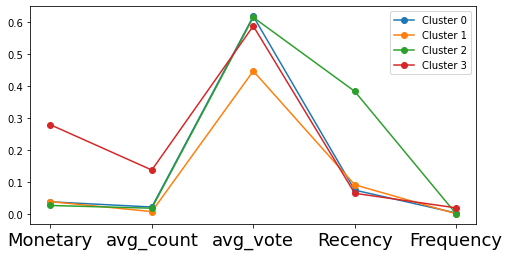

In [ ]:
hist, bins = np.histogram(companies_kmeans.labels_, bins=range(0, len(set(companies_kmeans.labels_)) + 1))
print(dict(zip(bins, hist)))

plt.figure(figsize=(8, 4))
for i in range(0, len(companies_kmeans.cluster_centers_)):
    plt.plot(companies_kmeans.cluster_centers_[i], marker='o', label='Cluster %s' % i)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.xticks(range(0, len(companies_df_copy.columns)), companies_df_copy.columns, fontsize=18)
plt.legend(fontsize=10)
plt.savefig('/content/drive/MyDrive/BDA/image/companies_cluster.png', format='png')
plt.show()

In this image we can see the separation of the centroids with respect to the attributes. Probably the discriminating factor in this case was the average vote.

In [ ]:
companies_df['K-Means_Labels'] = companies_kmeans.labels_
companies_df.head()

,companies,Monetary,avg_count,avg_vote,Recency,Frequency,K-Means_Labels
0,Pixar Animation Studios,1.486667e+08,4454.333333,7.166667,0,18,3
1,TriStar Pictures,2.657033e+07,394.926471,6.058088,0,136,0
2,Teitler Film,6.500000e+07,1610.500000,6.500000,12,2,3
3,Interscope Communications,2.035158e+07,301.263158,5.600000,17,19,1
4,Warner Bros.,4.202192e+07,911.185654,6.301688,0,474,3


In [ ]:
companies_dic = companies_df[['companies','K-Means_Labels']].set_index('companies').to_dict()
df['labels'] = df['production_companies'].apply(lambda values: list(map(lambda x: companies_dic['K-Means_Labels'][x], values)))

for label in range(len(companies_kmeans.cluster_centers_)):
  df['companies_label_'+str(label)] = df['labels'].apply(
      lambda values: int(label in values)
  )

df = df.drop(['labels','production_companies'],axis=1)

We defined the new categorical features in our dataset, indicating the clusters each movie was grouped in.

#### **Encoding writer by Clustering:**

In [ ]:
df['writer'] = df['writer'].apply(ast.literal_eval).values.tolist()
s = df.apply(lambda x: pd.Series(x['writer']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'writers'

writ_df = df.drop('writer', axis=1).join(s).reset_index().drop('index', axis=1)
writ_df = writ_df[~writ_df['writers'].isnull()]
writer_df = writ_df[['writers']].drop_duplicates()
writer_df.shape

(8560, 1)

Extract RFM features from describing writer profile:

In [ ]:
max_year = writ_df.year.max()
writer_df['Lastyear'] = writ_df.groupby('writers')['year'].transform('max').astype('int')
writer_df['Monetary'] = writ_df.groupby('writers')['budget_tmdb'].transform('mean')
writer_df['avg_count'] = writ_df.groupby('writers')['vote_count'].transform('mean')
writer_df['avg_vote'] = writ_df.groupby('writers')['vote_average'].transform('mean')
writer_df['Recency'] = pd.Series(max_year - writer_df['Lastyear'])
writer_df['Frequency'] = writ_df.groupby('writers')['id'].transform('count')
writer_df = writer_df.drop('Lastyear', axis=1)
writer_df_copy = writer_df.copy()
writer_df_copy = writer_df_copy.drop('writers', axis=1)
writer_df.head()

,writers,Monetary,avg_count,avg_vote,Recency,Frequency
0,John Lasseter,1.157143e+08,3295.000000,6.785714,4,7
1,Pete Docter,1.275000e+08,5950.500000,7.666667,2,6
2,Jonathan Hensleigh,6.828571e+07,1312.714286,6.414286,6,7
3,Greg Taylor,3.850000e+07,1230.000000,6.300000,21,2
4,Mark Steven Johnson,4.800000e+07,640.900000,5.470000,10,10


In [ ]:
if (Path('/content/drive/MyDrive/BDA/model/writers_kmeans.joblib').is_file() & 
    Path('/content/drive/MyDrive/BDA/image/writers_kmeans.png').is_file()) :
  writers_kmeans = load('/content/drive/MyDrive/BDA/model/writers_kmeans.joblib')
else:
  # Normalization by Min-Max:
  scaler_m = MinMaxScaler()
  X_m = scaler_m.fit_transform(writer_df_copy.values)

  sse_list = list()
  max_k = 10
  for k in range(2, max_k + 1):
      kmeans = KMeans(n_clusters = k, n_init=10, max_iter=100, random_state=0)
      kmeans.fit(X_m)
      
      sse = kmeans.inertia_
      sse_list.append(sse)
      
  plt.plot(range(2, len(sse_list) + 2), sse_list,'-o')
  plt.ylabel('SSE', fontsize=20)
  plt.xlabel('K', fontsize=20)
  plt.tick_params(axis='both', which='major', labelsize=15)
  plt.tight_layout()
  plt.savefig('/content/drive/MyDrive/BDA/image/writers_kmeans.png', format='png')
  plt.show()
  plt.close()

  writers_kmeans = KMeans(n_clusters=5, n_init=10, max_iter=100, random_state=0)
  writers_kmeans.fit(X_m)
  dump(writers_kmeans, '/content/drive/MyDrive/BDA/model/writers_kmeans.joblib') 

<img src = 'https://drive.google.com/uc?id=16OMOwAbTsMpEo8PxzC9inSPfNwzpjUDf'>

{0: 793, 1: 3626, 2: 451, 3: 1644, 4: 2046}


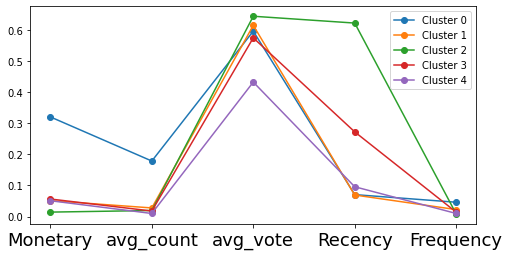

In [ ]:
hist, bins = np.histogram(writers_kmeans.labels_, bins=range(0, len(set(writers_kmeans.labels_)) + 1))
print(dict(zip(bins, hist)))

plt.figure(figsize=(8, 4))
for i in range(0, len(writers_kmeans.cluster_centers_)):
    plt.plot(writers_kmeans.cluster_centers_[i], marker='o', label='Cluster %s' % i)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.xticks(range(0, len(writer_df_copy.columns)), writer_df_copy.columns, fontsize=18)
plt.legend(fontsize=10)
plt.savefig('/content/drive/MyDrive/BDA/image/writer_cluster.png', format='png')
plt.show()

In this case, in addition to 'avg vote', also 'recency' seems to have been decisive for the division.


In [ ]:
writer_df['K-Means_Labels'] = writers_kmeans.labels_
writer_df.head()

,writers,Monetary,avg_count,avg_vote,Recency,Frequency,K-Means_Labels
0,John Lasseter,1.157143e+08,3295.000000,6.785714,4,7,0
1,Pete Docter,1.275000e+08,5950.500000,7.666667,2,6,0
2,Jonathan Hensleigh,6.828571e+07,1312.714286,6.414286,6,7,0
3,Greg Taylor,3.850000e+07,1230.000000,6.300000,21,2,3
4,Mark Steven Johnson,4.800000e+07,640.900000,5.470000,10,10,4


In [ ]:
writer_dic = writer_df[['writers','K-Means_Labels']].set_index('writers').to_dict()
df['labels'] = df['writer'].apply(lambda values: list(map(lambda x: writer_dic['K-Means_Labels'][x], values)))

for label in range(len(writers_kmeans.cluster_centers_)):
  df['writer_label_'+str(label)] = df['labels'].apply(
      lambda values: int(label in values)
  )

df = df.drop(['labels','writer'],axis=1)

#### **Encoding director by Clustering:**

In [ ]:
s = df.apply(lambda x: pd.Series(x['director_tmdb']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'directors'

dir_df = df.drop('director_tmdb', axis=1).join(s).reset_index().drop('index', axis=1)
dir_df = dir_df[~dir_df['directors'].isnull()]
director_df = dir_df[['directors']].drop_duplicates()
director_df.shape

(4065, 1)

Extract RFM features from describing director profile:

In [ ]:
max_year = dir_df.year.max()
director_df['Lastyear'] = dir_df.groupby('directors')['year'].transform('max').astype('int')
director_df['Monetary'] = dir_df.groupby('directors')['budget_tmdb'].transform('mean')
director_df['avg_count'] = dir_df.groupby('directors')['vote_count'].transform('mean')
director_df['avg_vote'] = dir_df.groupby('directors')['vote_average'].transform('mean')
director_df['Recency'] = pd.Series(max_year - director_df['Lastyear'])
director_df['Frequency'] = dir_df.groupby('directors')['id'].transform('count')
director_df = director_df.drop('Lastyear', axis=1)
director_df_copy = director_df.copy()
director_df_copy = director_df_copy.drop('directors', axis=1)
director_df.head()

,directors,Monetary,avg_count,avg_vote,Recency,Frequency
0,John Lasseter,1.120000e+08,3557.400000,6.840000,6,5
1,Joe Johnston,7.488889e+07,1559.666667,6.355556,6,9
2,Howard Deutch,2.657143e+07,183.428571,6.014286,9,7
3,Forest Whitaker,2.533333e+07,97.333333,5.766667,13,3
4,Charles Shyer,3.420000e+07,101.600000,5.500000,13,5


In [ ]:
if (Path('/content/drive/MyDrive/BDA/model/directors_kmeans.joblib').is_file() & 
    Path('/content/drive/MyDrive/BDA/image/directors_kmeans.png').is_file()) :
  directors_kmeans = load('/content/drive/MyDrive/BDA/model/directors_kmeans.joblib')
else:
  # Normalization by Min-Max:
  scaler_m = MinMaxScaler()
  X_m = scaler_m.fit_transform(director_df_copy.values)

  sse_list = list()
  max_k = 10
  for k in range(2, max_k + 1):
      kmeans = KMeans(n_clusters = k, n_init=10, max_iter=100, random_state=0)
      kmeans.fit(X_m)
      
      sse = kmeans.inertia_
      sse_list.append(sse)
      
  plt.plot(range(2, len(sse_list) + 2), sse_list,'-o')
  plt.ylabel('SSE', fontsize=20)
  plt.xlabel('K', fontsize=20)
  plt.tick_params(axis='both', which='major', labelsize=15)
  plt.tight_layout()
  plt.savefig('/content/drive/MyDrive/BDA/image/directors_kmeans.png', format='png')
  plt.show()
  plt.close()

  directors_kmeans = KMeans(n_clusters=4, n_init=10, max_iter=100, random_state=0)
  directors_kmeans.fit(X_m)
  dump(directors_kmeans, '/content/drive/MyDrive/BDA/model/directors_kmeans.joblib') 

<img src = 'https://drive.google.com/uc?id=16a1zAtUjqYCCB2BbrZ88BN8a9jaQBcgX'>

{0: 1270, 1: 399, 2: 2067, 3: 329}


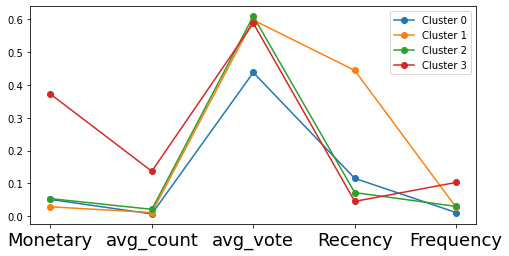

In [ ]:
hist, bins = np.histogram(directors_kmeans.labels_, bins=range(0, len(set(directors_kmeans.labels_)) + 1))
print(dict(zip(bins, hist)))

plt.figure(figsize=(8, 4))
for i in range(0, len(directors_kmeans.cluster_centers_)):
    plt.plot(directors_kmeans.cluster_centers_[i], marker='o', label='Cluster %s' % i)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.xticks(range(0, len(director_df_copy.columns)), director_df_copy.columns, fontsize=18)
plt.legend(fontsize=10)
plt.savefig('/content/drive/MyDrive/BDA/image/director_cluster.png', format='png')
plt.show()

In [ ]:
director_df['K-Means_Labels'] = directors_kmeans.labels_
director_df.head()

,directors,Monetary,avg_count,avg_vote,Recency,Frequency,K-Means_Labels
0,John Lasseter,1.120000e+08,3557.400000,6.840000,6,5,3
1,Joe Johnston,7.488889e+07,1559.666667,6.355556,6,9,3
2,Howard Deutch,2.657143e+07,183.428571,6.014286,9,7,2
3,Forest Whitaker,2.533333e+07,97.333333,5.766667,13,3,2
4,Charles Shyer,3.420000e+07,101.600000,5.500000,13,5,0


In [ ]:
director_dic = director_df[['directors','K-Means_Labels']].set_index('directors').to_dict()
df['labels'] = df['director_tmdb'].apply(lambda value: director_dic['K-Means_Labels'][value])

for label in range(len(directors_kmeans.cluster_centers_)):
  df['director_label_'+str(label)] = df['labels'].apply(
      lambda value: int(label == value)
  )

df = df.drop(['labels','director_tmdb'],axis=1)

#### **Encoding actors by Clustering:**

In [ ]:
df['actors_tmdb'] = df['actors_tmdb'].apply(ast.literal_eval).values.tolist()
s = df.apply(lambda x: pd.Series(x['actors_tmdb']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'actors'

act_df = df.drop('actors_tmdb', axis=1).join(s).reset_index().drop('index', axis=1)
act_df = act_df[~act_df['actors'].isnull()]
actor_df = act_df[['actors']].drop_duplicates()
actor_df.shape

(9963, 1)

Extract RFM features from describing actor profile:

In [ ]:
max_year = act_df.year.max()
actor_df['Lastyear'] = act_df.groupby('actors')['year'].transform('max').astype('int')
actor_df['Monetary'] = act_df.groupby('actors')['budget_tmdb'].transform('mean')
actor_df['avg_count'] = act_df.groupby('actors')['vote_count'].transform('mean')
actor_df['avg_vote'] = act_df.groupby('actors')['vote_average'].transform('mean')
actor_df['Recency'] = pd.Series(max_year - actor_df['Lastyear'])
actor_df['Frequency'] = act_df.groupby('actors')['id'].transform('count')
actor_df = actor_df.drop('Lastyear', axis=1)
actor_df_copy = actor_df.copy()
actor_df_copy = actor_df_copy.drop('actors', axis=1)
actor_df.head()

,actors,Monetary,avg_count,avg_vote,Recency,Frequency
0,Tom Hanks,5.352381e+07,1738.785714,6.652381,0,42
1,Tim Allen,4.535294e+07,980.647059,5.888235,4,17
2,Don Rickles,1.700000e+07,2803.000000,7.450000,22,2
3,Robin Williams,3.845854e+07,667.951220,6.219512,4,41
4,Jonathan Hyde,6.500000e+07,2413.000000,6.900000,22,1


In [ ]:
if (Path('/content/drive/MyDrive/BDA/model/actors_kmeans.joblib').is_file() & 
    Path('/content/drive/MyDrive/BDA/image/actors_kmeans.png').is_file()) :
  actors_kmeans = load('/content/drive/MyDrive/BDA/model/actors_kmeans.joblib')
else:
  #Normalization by Min-Max:
  scaler_m = MinMaxScaler()
  X_m = scaler_m.fit_transform(actor_df_copy.values)

  sse_list = list()
  max_k = 10
  for k in range(2, max_k + 1):
      kmeans = KMeans(n_clusters = k, n_init=10, max_iter=100, random_state=0)
      kmeans.fit(X_m)
      
      sse = kmeans.inertia_
      sse_list.append(sse)
      
  plt.plot(range(2, len(sse_list) + 2), sse_list,'-o')
  plt.ylabel('SSE', fontsize=20)
  plt.xlabel('K', fontsize=20)
  plt.tick_params(axis='both', which='major', labelsize=15)
  plt.tight_layout()
  plt.savefig('/content/drive/MyDrive/BDA/image/actors_kmeans.png', format='png')
  plt.show()
  plt.close()

  actors_kmeans = KMeans(n_clusters=5, n_init=10, max_iter=100, random_state=0)
  actors_kmeans.fit(X_m)
  dump(actors_kmeans, '/content/drive/MyDrive/BDA/model/actors_kmeans.joblib') 

<img src = 'https://drive.google.com/uc?id=16j1Q_VTO1nuXoqQjoZnbCXRtLTpzqmyV'>

{0: 4065, 1: 2576, 2: 934, 3: 593, 4: 1795}


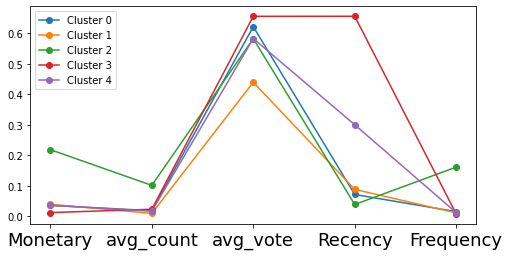

In [ ]:
hist, bins = np.histogram(actors_kmeans.labels_, bins=range(0, len(set(actors_kmeans.labels_)) + 1))
print(dict(zip(bins, hist)))

plt.figure(figsize=(8, 4))
for i in range(0, len(actors_kmeans.cluster_centers_)):
    plt.plot(actors_kmeans.cluster_centers_[i], marker='o', label='Cluster %s' % i)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.xticks(range(0, len(actor_df_copy.columns)), actor_df_copy.columns, fontsize=18)
plt.legend(fontsize=10)
plt.savefig('/content/drive/MyDrive/BDA/image/actor_cluster.png', format='png')
plt.show()

In [ ]:
actor_df['K-Means_Labels'] = actors_kmeans.labels_
actor_df.head()

,actors,Monetary,avg_count,avg_vote,Recency,Frequency,K-Means_Labels
0,Tom Hanks,5.352381e+07,1738.785714,6.652381,0,42,2
1,Tim Allen,4.535294e+07,980.647059,5.888235,4,17,2
2,Don Rickles,1.700000e+07,2803.000000,7.450000,22,2,4
3,Robin Williams,3.845854e+07,667.951220,6.219512,4,41,2
4,Jonathan Hyde,6.500000e+07,2413.000000,6.900000,22,1,2


In [ ]:
actor_dic = actor_df[['actors','K-Means_Labels']].set_index('actors').to_dict()
df['labels'] = df['actors_tmdb'].apply(lambda values: list(map(lambda x: actor_dic['K-Means_Labels'][x], values)))

for label in range(len(actors_kmeans.cluster_centers_)):
  df['actor_label_'+str(label)] = df['labels'].apply(
      lambda values: int(label in values)
  )

df = df.drop(['labels','actors_tmdb'],axis=1)
df.to_csv('/content/drive/MyDrive/BDA/input/df_post.csv', index=False)

<a id='regs'></a>
### 2). Regressors ([to top](#top))

After further preparing our dataset for the analyzes, we decided to perform our prediction task first with a regression and then with a binary classification defined by a threshold. For both we will analyze in the order:
1. [Dummy](#dr)
2. [Decision Tree](#dtr)
3. [Decision Tree Bagging](#dtwbr)
4. [Random Forest](#rfr)
5. [Gradient Boosting](#gbr)
6. [Multilayer Perceptron](#mlpr)
7. [MLP with Bagging](#mlpwbr)
8. [Auto Sklearn (automated machine learning toolkit)](#asr)

We choose the dummy regressor as a lower-bound baseline since it always outputs a constant mean value. And an auto Sklearn model was used, automatically generating the pipeline for data preparation, feature selection, model selection, hype-parameter tuning, model ensembling, etc. We think it is a good benchmark for our model. The first model we tried is the decision tree since it is easy to read and interpret. Then to achieve a better performance, we attempted to bag the decision tree model we built and two different Sklearn built-in ensemble methods: Randomforest and GeadientBoosting. We also tried MLP to check if the NN could bring us a better performance.

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/BDA/input/df_post.csv', keep_default_na=False)
return_df = df[df.columns.difference(['overview', 'tagline', 'title_tmdb','keywords', 'id', 'avg_vote', 'votes'])]
return_df.to_csv('/content/drive/MyDrive/BDA/input/return_df_post.csv', index=False)
X, y = return_df.drop(['revenue', 'return', 'return_log'], axis=1), return_df['return_log']
train_X, test_X, train_y, test_y = train_test_split(X, y, train_size=0.75, test_size=0.25, random_state=0)

<a id='dr'></a>
#### DummyRegressor ([to top](#top))

First we used a Dummy regressor that makes predictions using simple rules. This is useful as a simple baseline to compare with other regressors.

In [ ]:
dr = DummyRegressor()
dr.fit(train_X, train_y)

DummyRegressor()

In [ ]:
test_predictions = dr.predict(test_X)
dr_results = {
    "RMSE" : np.sqrt(mean_squared_error(test_y, test_predictions)),
    "MAE" : mean_absolute_error(test_y, test_predictions),
    "R2" : dr.score(test_X, test_y),
    "PEARSONR" : pearsonr(test_y.values, test_predictions)[0]
}
print("Test RMSE : {:.4f}".format(dr_results['RMSE']))
print("Test MAE : {:.4f}".format(dr_results['MAE']))
print("Test R2 : {:.4f}".format(dr_results['R2']))
print("Test PEARSONR : {:.4f}".format(float(dr_results['PEARSONR'])))

Test RMSE : 2.5134
Test MAE : 1.7310
Test R2 : -0.0002
Test PEARSONR : nan


<a id='dtr'></a>
#### DecisionTreeRegressor ([to top](#top))

As a first (real) regressor we used a decision tree, which breaks down a dataset into smaller and smaller subsets while at the same time an associated decision tree is incrementally developed.


In [ ]:
if not Path('/content/drive/MyDrive/BDA/image/dtr_rfe.png').is_file():
  X, y = return_df.drop(['revenue', 'return', 'return_log'], axis=1), return_df['return_log']
  train_X, test_X, train_y, test_y = train_test_split(X, y, train_size=0.2, test_size=0.8, random_state=0)

  # get a list of models to evaluate
  def get_models():
    models = dict()
    for i in range(2, train_X.shape[1], 4):
      rfe = RFE(estimator=DecisionTreeRegressor(random_state = 0), n_features_to_select=i)
      model = DecisionTreeRegressor(random_state = 0)
      models[str(i)] = Pipeline(steps=[('s', rfe), ('m', model)])
    return models

  # evaluate a give model using cross-validation
  def evaluate_model(model, X, y):
    cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=0)
    scores = cross_val_score(model, X, y, scoring='r2', cv=cv, n_jobs=-1, error_score='raise')
    return scores

  # get the models to evaluate
  models = get_models()

  # evaluate the models and store results
  results, names = list(), list()
  for name, model in models.items():
    scores = evaluate_model(model, train_X, train_y)
    results.append(scores)
    names.append(name)
    print('%s %.3f (%.3f)' % (name, mean(scores), std(scores)))

  # plot model performance for comparison
  plt.boxplot(results, labels=names, showmeans=True)
  plt.xlabel('number of features', fontsize=20)
  plt.ylabel('scores', fontsize=20)
  plt.grid(alpha=0.2)
  plt.tight_layout()
  plt.savefig('/content/drive/MyDrive/BDA/image/dtr_rfe.png', format='png')
  plt.show()
  plt.close()

<img src = 'https://drive.google.com/uc?id=11YQ_GlIxEgiTNtPiucl7EJoNEyatQdDY'>

Before strarting, we performed a features selection, using recursive feature elimination (RFE). Then, we executed the RepeatedKFold cross-validation in order to flag problems like overfitting or selection bias and to give an insight on how the model will generalize to an independent dataset. This operation together with hyper-parameter tuning will be performed for each model in this notebook.

In [ ]:
if Path('/content/drive/MyDrive/BDA/model/dtr_rfe_support.npy').is_file():
  dtr_rfe_support = np.load('/content/drive/MyDrive/BDA/model/dtr_rfe_support.npy')

  X, y = return_df.drop(['revenue', 'return', 'return_log'], axis=1), return_df['return_log']

  train_X, test_X, train_y, test_y = train_test_split(X, y, train_size=0.75, test_size=0.25, random_state=0)
  train_X, test_X = train_X.loc[:, dtr_rfe_support], test_X.loc[:, dtr_rfe_support]

else:
  train_X, test_X, train_y, test_y = train_test_split(X, y, train_size=0.75, test_size=0.25, random_state=0)

  # create pipeline
  rfe = RFE(estimator=DecisionTreeRegressor(random_state = 0), n_features_to_select=46)

  # let's create a pipeline
  model = DecisionTreeRegressor(random_state = 0)

  # create a pipeline
  pipeline = Pipeline(steps=[('s', rfe), ('m', model)])

  # evaluate model
  cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=0)
  n_scores = cross_val_score(model, train_X, train_y, scoring='r2', cv=cv, n_jobs=-1, error_score='raise')

  # report performance
  print('r2_score for cv: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

  pipeline.fit(train_X, train_y)
  scores = pipeline.score(test_X, test_y)

  # report performance
  print('r2_score for testset: %.3f (%.3f)' % (mean(scores), std(scores)))

  train_X, test_X = train_X.loc[:, rfe.support_], test_X.loc[:, rfe.support_]
  np.save('/content/drive/MyDrive/BDA/model/dtr_rfe_support.npy', rfe.support_)

For the validation metric, R-square was chosen since R-square can be thought of as a rescaling of MSE, comparing it to the variance of the outcome response. And it's also nice to interpret because the best possible score is 1.0.

As anticipated, for better results it is important a hyper-parameter tuning, to choose the best criterion of splitting, the depth of our tree and so on.


In [ ]:
if Path('/content/drive/MyDrive/BDA/model/DecisionTreeRegressor.joblib').is_file():
  dtr = load('/content/drive/MyDrive/BDA/model/DecisionTreeRegressor.joblib')

else:
  # Create the grid
  params = {'criterion' : ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
            'splitter' : ['best', 'random'],
            'max_depth' : [2, 5, 10, 15, 20, 25, None],
            'min_samples_split' : [100, 150, 200],
            'min_samples_leaf': [2, 5, 10, 15, 20, 25]}

  #define the grid search
  grid_search_cv = GridSearchCV(DecisionTreeRegressor(random_state=0),params,verbose=1,cv=5,scoring='r2',n_jobs=-1)

  #run the grid search
  grid_search_cv.fit(train_X, train_y)

  dump(grid_search_cv.best_estimator_, '/content/drive/MyDrive/BDA/model/DecisionTreeRegressor.joblib') 
  dtr = grid_search_cv.best_estimator_

print(dtr)

DecisionTreeRegressor(criterion='friedman_mse', max_depth=15,
                      min_samples_leaf=10, min_samples_split=150,
                      random_state=0)


In [ ]:
test_predictions = dtr.predict(test_X)
dtr_results = {
    "RMSE" : np.sqrt(mean_squared_error(test_y, test_predictions)),
    "MAE" : mean_absolute_error(test_y, test_predictions),
    "R2" : dtr.score(test_X, test_y),
    "PEARSONR" : pearsonr(test_y.values, test_predictions)[0]
}
print("Test RMSE : {:.4f}".format(dtr_results['RMSE']))
print("Test MAE : {:.4f}".format(dtr_results['MAE']))
print("Test R2 : {:.4f}".format(dtr_results['R2']))
print("Test PEARSONR : {:.4f}".format(dtr_results['PEARSONR']))

Test RMSE : 1.9908
Test MAE : 1.3494
Test R2 : 0.3725
Test PEARSONR : 0.6108


Obviously the results obtained are better than the dummy regressor and honestly they are even higher than our expectations, already at the first regressor.

<a id='dtwbr'></a>
#### DecisionTree with BaggingRegressor ([to top](#top))

So, we decided to add Bagging (bootstrap aggregating) to our model, looking to further improve performance. Indeed bagging  is an ensemble method that fits base regressors each on random subsets of the original dataset and then aggregate their individual predictions. This can be crucial to reduce the variance and the noise.

In [ ]:
if Path('/content/drive/MyDrive/BDA/model/dtr_BaggingRegressor.joblib').is_file():
  dtr_bagging = load('/content/drive/MyDrive/BDA/model/dtr_BaggingRegressor.joblib') 

else:
  dtr_bagging = BaggingRegressor(base_estimator=dtr, n_estimators=50, max_samples=0.8, max_features=0.8, random_state=0).fit(train_X,train_y)
  dump(dtr_bagging, '/content/drive/MyDrive/BDA/model/dtr_BaggingRegressor.joblib')

print(dtr_bagging)

BaggingRegressor(base_estimator=DecisionTreeRegressor(criterion='friedman_mse',
                                                      max_depth=15,
                                                      min_samples_leaf=10,
                                                      min_samples_split=150,
                                                      random_state=0),
                 max_features=0.8, max_samples=0.8, n_estimators=50,
                 random_state=0)


In [ ]:
test_predictions = dtr_bagging.predict(test_X)
dtr_bagging_results = {
    "RMSE" : np.sqrt(mean_squared_error(test_y, test_predictions)),
    "MAE" : mean_absolute_error(test_y, test_predictions),
    "R2" : dtr_bagging.score(test_X, test_y),
    "PEARSONR" : pearsonr(test_y.values, test_predictions)[0]
}
print("Test RMSE : {:.4f}".format(dtr_bagging_results['RMSE']))
print("Test MAE : {:.4f}".format(dtr_bagging_results['MAE']))
print("Test R2 : {:.4f}".format(dtr_bagging_results['R2']))
print("Test PEARSONR : {:.4f}".format(dtr_bagging_results['PEARSONR']))

Test RMSE : 1.9465
Test MAE : 1.2985
Test R2 : 0.4001
Test PEARSONR : 0.6534


As you can see not only reduced the error, but we also improved the prediction and consequently the correlation between the variables.


<a id='rfr'></a>
#### RandomForestRegressor ([to top](#top))

The next model might look like a repetition of bagging, with the difference however thtat Random Forest selects (a random) only a subset of attributes. So, the trees are more independent of each other compared to regular bagging, which often results in better predictive performance.


In [ ]:
if not Path('/content/drive/MyDrive/BDA/image/rfr_rfe.png').is_file():
  X, y = return_df.drop(['revenue', 'return', 'return_log'], axis=1), return_df['return_log']
  train_X, test_X, train_y, test_y = train_test_split(X, y, train_size=0.2, test_size=0.8, random_state=0)

  # get a list of models to evaluate
  def get_models():
    models = dict()
    for i in range(2, train_X.shape[1], 4):
      rfe = RFE(estimator=RandomForestRegressor(random_state = 0), n_features_to_select=i)
      model = RandomForestRegressor(random_state = 0)
      models[str(i)] = Pipeline(steps=[('s', rfe), ('m', model)])
    return models

  # evaluate a give model using cross-validation
  def evaluate_model(model, X, y):
    cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=0)
    scores = cross_val_score(model, X, y, scoring='r2', cv=cv, n_jobs=-1, error_score='raise')
    return scores

  # get the models to evaluate
  models = get_models()

  # evaluate the models and store results
  results, names = list(), list()
  for name, model in models.items():
    scores = evaluate_model(model, train_X, train_y)
    results.append(scores)
    names.append(name)
    print('%s %.3f (%.3f)' % (name, mean(scores), std(scores)))

  # plot model performance for comparison
  plt.boxplot(results, labels=names, showmeans=True)
  plt.xlabel('number of features', fontsize=20)
  plt.ylabel('scores', fontsize=20)
  plt.grid(alpha=0.2)
  plt.tight_layout()
  plt.savefig('/content/drive/MyDrive/BDA/image/rfr_rfe.png', format='png')
  plt.show()
  plt.close()

<img src = 'https://drive.google.com/uc?id=10PRYl7jva3mweAsJtZPMKnen1YxgMCKr'>

The first thing to note is that random forest needs far fewer features than the decision tree. Only 34 against the 46 previously chosen. In high-dimensional dataset, this is essential not only to reduce computation time and resources, but also to prevent overfitting. 

In [ ]:
if Path('/content/drive/MyDrive/BDA/model/rfr_rfe_support.npy').is_file():
  rfr_rfe_support = np.load('/content/drive/MyDrive/BDA/model/rfr_rfe_support.npy')

  X, y = return_df.drop(['revenue', 'return', 'return_log'], axis=1), return_df['return_log']

  train_X, test_X, train_y, test_y = train_test_split(X, y, train_size=0.75, test_size=0.25, random_state=0)
  train_X, test_X = train_X.loc[:, rfr_rfe_support], test_X.loc[:, rfr_rfe_support]

else:
  train_X, test_X, train_y, test_y = train_test_split(X, y, train_size=0.75, test_size=0.25, random_state=0)

  # create pipeline
  rfe = RFE(estimator=RandomForestRegressor(random_state = 0), n_features_to_select=34)

  # let's create a pipeline
  model = RandomForestRegressor(random_state = 0)

  # create a pipeline
  pipeline = Pipeline(steps=[('s', rfe), ('m', model)])

  # evaluate model
  cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=0)
  n_scores = cross_val_score(model, train_X, train_y, scoring='r2', cv=cv, n_jobs=-1, error_score='raise')

  # report performance
  print('r2_score for cv: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

  pipeline.fit(train_X, train_y)
  scores = pipeline.score(test_X, test_y)

  # report performance
  print('r2_score for testset: %.3f (%.3f)' % (mean(scores), std(scores)))

  train_X, test_X = train_X.loc[:, rfe.support_], test_X.loc[:, rfe.support_]
  np.save('/content/drive/MyDrive/BDA/model/rfr_rfe_support.npy', rfe.support_)

In [ ]:
if Path('/content/drive/MyDrive/BDA/model/RandomForestRegressor.joblib').is_file():
  rfr = load('/content/drive/MyDrive/BDA/model/RandomForestRegressor.joblib')

else:
  # Create the random grid
  params = {'n_estimators': [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)],
                'min_samples_split': [2, 5, 7],
                'min_samples_leaf': [2, 5, 7]}

  #define the grid search
  grid_search_cv = RandomizedSearchCV(RandomForestRegressor(random_state = 0),params,n_iter=50,cv=5,verbose=2,random_state=0,n_jobs=-1)

  #run the grid search
  grid_search_cv.fit(train_X, train_y)

  dump(grid_search_cv.best_estimator_, '/content/drive/MyDrive/BDA/model/RandomForestRegressor.joblib')
  rfr = grid_search_cv.best_estimator_

print(rfr)

RandomForestRegressor(min_samples_leaf=5, n_estimators=500, random_state=0)


In [ ]:
test_predictions = rfr.predict(test_X)
rfr_results = {
    "RMSE" : np.sqrt(mean_squared_error(test_y, test_predictions)),
    "MAE" : mean_absolute_error(test_y, test_predictions),
    "R2" : rfr.score(test_X, test_y),
    "PEARSONR" : pearsonr(test_y.values, test_predictions)[0]
}
print("Test RMSE : {:.4f}".format(rfr_results['RMSE']))
print("Test MAE : {:.4f}".format(rfr_results['MAE']))
print("Test R2 : {:.4f}".format(rfr_results['R2']))
print("Test PEARSONR : {:.4f}".format(rfr_results['PEARSONR']))

Test RMSE : 1.8107
Test MAE : 1.2238
Test R2 : 0.4809
Test PEARSONR : 0.6973


After tuning, we see that random forest has significantly improved the performance. Even bringing the pearson correlation to a significant 0.70. The Pearson correlation coefficient measures the linear relationship between two dimension. Thus, the closer it is to 1.0, the closer our prediction comes to reality. Same speech for R2, the closer it is to 1.0, the better observed outcomes are replicated by the model.


<a id='gbr'></a>
#### GradientBoostingRegressor ([to top](#top))

In order to minimize the bias error (erroneous assumption in the learning algorithm) of the regression, we applied this method that as the other ensamble method did, it works on weak learner like decision tree, adding one by one tree. Unlike random forest, instead of training a new estimator on the data to predict the target, it trains an estimator to predict the residuals of the first predictor. Using that value in the base estimator.

In [ ]:
if not Path('/content/drive/MyDrive/BDA/image/gbr_rfe.png').is_file():
  X, y = return_df.drop(['revenue', 'return', 'return_log'], axis=1), return_df['return_log']
  train_X, test_X, train_y, test_y = train_test_split(X, y, train_size=0.2, test_size=0.8, random_state=0)

  # get a list of models to evaluate
  def get_models():
    models = dict()
    for i in range(2, train_X.shape[1], 4):
      rfe = RFE(estimator=GradientBoostingRegressor(random_state = 0), n_features_to_select=i)
      model = GradientBoostingRegressor(random_state = 0)
      models[str(i)] = Pipeline(steps=[('s', rfe), ('m', model)])
    return models

  # evaluate a give model using cross-validation
  def evaluate_model(model, X, y):
    cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=0)
    scores = cross_val_score(model, X, y, scoring='r2', cv=cv, n_jobs=-1, error_score='raise')
    return scores

  # get the models to evaluate
  models = get_models()

  # evaluate the models and store results
  results, names = list(), list()
  for name, model in models.items():
    scores = evaluate_model(model, train_X, train_y)
    results.append(scores)
    names.append(name)
    print('%s %.3f (%.3f)' % (name, mean(scores), std(scores)))

  # plot model performance for comparison
  plt.boxplot(results, labels=names, showmeans=True)
  plt.xlabel('number of features', fontsize=20)
  plt.ylabel('scores', fontsize=20)
  plt.grid(alpha=0.2)
  plt.tight_layout()
  plt.savefig('/content/drive/MyDrive/BDA/image/gbr_rfe.png', format='png')
  plt.show()
  plt.close()

<img src = 'https://drive.google.com/uc?id=10cIPClhi5KycWvEQw6Y6nD6LOmm2BeVJ'>

Also in this decision tree based model, it is reduced the number of features needed to execute a good regression. (30 instead of 34).

In [ ]:
if Path('/content/drive/MyDrive/BDA/model/gbr_rfe_support.npy').is_file():
  gbr_rfe_support = np.load('/content/drive/MyDrive/BDA/model/gbr_rfe_support.npy')

  X, y = return_df.drop(['revenue', 'return', 'return_log'], axis=1), return_df['return_log']

  train_X, test_X, train_y, test_y = train_test_split(X, y, train_size=0.75, test_size=0.25, random_state=0)
  train_X, test_X = train_X.loc[:, gbr_rfe_support], test_X.loc[:, gbr_rfe_support]

else:
  train_X, test_X, train_y, test_y = train_test_split(X, y, train_size=0.75, test_size=0.25, random_state=0)

  # create pipeline
  rfe = RFE(estimator=GradientBoostingRegressor(random_state = 0), n_features_to_select=30)

  # let's create a pipeline
  model = GradientBoostingRegressor(random_state = 0)

  # create a pipeline
  pipeline = Pipeline(steps=[('s', rfe), ('m', model)])

  # evaluate model
  cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=0)
  n_scores = cross_val_score(model, train_X, train_y, scoring='r2', cv=cv, n_jobs=-1, error_score='raise')

  # report performance
  print('r2_score for cv: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

  pipeline.fit(train_X, train_y)
  scores = pipeline.score(test_X, test_y)

  # report performance
  print('r2_score for testset: %.3f (%.3f)' % (mean(scores), std(scores)))

  train_X, test_X = train_X.loc[:, rfe.support_], test_X.loc[:, rfe.support_]
  np.save('/content/drive/MyDrive/BDA/model/gbr_rfe_support.npy', rfe.support_)

In [ ]:
if Path('/content/drive/MyDrive/BDA/model/GradientBoostingRegressor.joblib').is_file():
  gbr = load('/content/drive/MyDrive/BDA/model/GradientBoostingRegressor.joblib')

else:
  # Create the grid
  params = {'learning_rate': [0.1, 0.01, 0.001],
            'subsample'    : [0.9, 0.5, 0.3],
            'n_estimators' : [200, 500, 1000],
            'max_depth'    : [4, 6, 8]}

  #define the grid search
  grid_search_cv = GridSearchCV(GradientBoostingRegressor(random_state=0),params,verbose=1,cv=5,scoring='r2',n_jobs=-1)

  #run the grid search
  grid_search_cv.fit(train_X, train_y)

  dump(grid_search_cv.best_estimator_, '/content/drive/MyDrive/BDA/model/GradientBoostingRegressor.joblib') 
  gbr = grid_search_cv.best_estimator_

print(gbr)

GradientBoostingRegressor(learning_rate=0.01, max_depth=6, n_estimators=500,
                          random_state=0, subsample=0.5)


The more inexplicable the black box becomes, the more important becomes to tune the parameters, such as the number of estimator: 500 in our case.

In [ ]:
test_predictions = gbr.predict(test_X)
gbr_results = {
    "RMSE" : np.sqrt(mean_squared_error(test_y, test_predictions)),
    "MAE" : mean_absolute_error(test_y, test_predictions),
    "R2" : gbr.score(test_X, test_y),
    "PEARSONR" : pearsonr(test_y.values, test_predictions)[0]
}
print("Test RMSE : {:.4f}".format(gbr_results['RMSE']))
print("Test MAE : {:.4f}".format(gbr_results['MAE']))
print("Test R2 : {:.4f}".format(gbr_results['R2']))
print("Test PEARSONR : {:.4f}".format(gbr_results['PEARSONR']))

Test RMSE : 1.8106
Test MAE : 1.2204
Test R2 : 0.4809
Test PEARSONR : 0.6984


Unlikely, our work has resulted in a slight improvement over the random forest. Despite this, it remains an excellent result.

<a id='mlpr'></a>
#### MLPRegressor ([to top](#top))

The next model used is the simplest of the artificial neural network.

In [ ]:
X, y = return_df.drop(['revenue', 'return', 'return_log'], axis=1), return_df['return_log']
data = X
data.insert(len(data.columns), 'return_log', y)
scaler_m = MinMaxScaler()
data_m = scaler_m.fit_transform(data.values)
X_m = data_m[:, 0:len(data.columns)-1]
y_m = data_m[:,len(data.columns)-1]
train_X, test_X, train_y, test_y = train_test_split(X_m, y_m, train_size=0.75, test_size=0.25, random_state=0)

In [ ]:
if Path('/content/drive/MyDrive/BDA/model/MLPRegressor.joblib').is_file():
  mlpr = load('/content/drive/MyDrive/BDA/model/MLPRegressor.joblib')
  
else:
  params = {"hidden_layer_sizes": [(1,),(3,),(5,),(7,)],
            "activation": ["identity", "logistic", "tanh", "relu"],
            "solver": ["lbfgs", "sgd", "adam"],
            "alpha": [0.0001, 0.0005,0.001]}

  grid_search_cv = GridSearchCV(MLPRegressor(random_state = 0, early_stopping=True, max_iter=1000),params,verbose=1,cv=5,scoring='r2',n_jobs=-1)
  grid_search_cv.fit(train_X,train_y)
  dump(grid_search_cv.best_estimator_, '/content/drive/MyDrive/BDA/model/MLPRegressor.joblib')
  mlpr = grid_search_cv.best_estimator_

print(mlpr)

MLPRegressor(early_stopping=True, hidden_layer_sizes=(5,), max_iter=1000,
             random_state=0)


In [ ]:
test_predictions = mlpr.predict(test_X)
mlpr_results = {
    "RMSE" : np.sqrt(mean_squared_error(scaler_m.inverse_transform(np.column_stack([test_X, test_y]))[:,-1]
                                        , scaler_m.inverse_transform(np.column_stack([test_X,test_predictions]))[:,-1])),
    "MAE" : mean_absolute_error(scaler_m.inverse_transform(np.column_stack([test_X, test_y]))[:,-1]
                                        , scaler_m.inverse_transform(np.column_stack([test_X,test_predictions]))[:,-1]),
    "R2" : mlpr.score(test_X, test_y),
    "PEARSONR" : pearsonr(scaler_m.inverse_transform(np.column_stack([test_X, test_y]))[:,-1]
                          , scaler_m.inverse_transform(np.column_stack([test_X,test_predictions]))[:,-1])[0]
}
print("Test RMSE : {:.4f}".format(mlpr_results['RMSE']))
print("Test MAE : {:.4f}".format(mlpr_results['MAE']))
print("Test R2 : {:.4f}".format(mlpr_results['R2']))
print("Test PEARSONR : {}".format(mlpr_results['PEARSONR']))

Test RMSE : 2.2101
Test MAE : 1.3940
Test R2 : 0.2266
Test PEARSONR : 0.47826993404093093


<a id='mlpwbr'></a>
#### MLP with BaggingRegressor ([to top](#top))

Since the first results were unsatisfactory, we decided to implent bagging on this predictor.

In [ ]:
if Path('/content/drive/MyDrive/BDA/model/mlpr_BaggingRegressor.joblib').is_file():
  mlpr_bagging = load('/content/drive/MyDrive/BDA/model/mlpr_BaggingRegressor.joblib') 

else:
  mlpr_bagging = BaggingRegressor(base_estimator=mlpr, n_estimators=50, max_samples=0.8, max_features=0.8, random_state=0).fit(train_X,train_y)
  dump(mlpr_bagging, '/content/drive/MyDrive/BDA/model/mlpr_BaggingRegressor.joblib')

print(mlpr_bagging)

BaggingRegressor(base_estimator=MLPRegressor(early_stopping=True,
                                             hidden_layer_sizes=(5,),
                                             max_iter=1000, random_state=0),
                 max_features=0.8, max_samples=0.8, n_estimators=50,
                 random_state=0)


In [ ]:
test_predictions = mlpr_bagging.predict(test_X)
mlpr_bagging_results = {
    "RMSE" : np.sqrt(mean_squared_error(scaler_m.inverse_transform(np.column_stack([test_X, test_y]))[:,-1]
                                        , scaler_m.inverse_transform(np.column_stack([test_X,test_predictions]))[:,-1])),
    "MAE" : mean_absolute_error(scaler_m.inverse_transform(np.column_stack([test_X, test_y]))[:,-1]
                                        , scaler_m.inverse_transform(np.column_stack([test_X,test_predictions]))[:,-1]),
    "R2" : mlpr.score(test_X, test_y),
    "PEARSONR" : pearsonr(scaler_m.inverse_transform(np.column_stack([test_X, test_y]))[:,-1]
                          , scaler_m.inverse_transform(np.column_stack([test_X,test_predictions]))[:,-1])[0]
}
print("Test RMSE : {:.4f}".format(mlpr_bagging_results['RMSE']))
print("Test MAE : {:.4f}".format(mlpr_bagging_results['MAE']))
print("Test R2 : {:.4f}".format(mlpr_bagging_results['R2']))
print("Test PEARSONR : {}".format(mlpr_bagging_results['PEARSONR']))

Test RMSE : 2.2739
Test MAE : 1.4486
Test R2 : 0.2266
Test PEARSONR : 0.43053081647801755


As opposite to what we expected, not only did the results not improve but also we lost both in terms of errors and correlation.


<a id='asr'></a>
####  AutoSklearnRegressor ([to top](#top))

The last regressor analyzed is a fully automated model. All processes from feature selection to tuning are performed by the regressor, making it a real black box.


In [ ]:
X, y = return_df.drop(['revenue', 'return', 'return_log'], axis=1), return_df['return_log']
train_X, test_X, train_y, test_y = train_test_split(X, y, train_size=0.75, test_size=0.25, random_state=0)

In [ ]:
if Path('/content/drive/MyDrive/BDA/model/AutoSklearnRegressor.joblib').is_file():
  asr = load('/content/drive/MyDrive/BDA/model/AutoSklearnRegressor.joblib') 
 
else:
  asr = autosklearn.regression.AutoSklearnRegressor(
      time_left_for_this_task=1000,
      per_run_time_limit=100,
      ensemble_size = 1000,
      ensemble_nbest = 1000,
      seed = 42,
      tmp_folder='/tmp/autosklearn_regression_example_tmp'
  )
  asr.fit(train_X, train_y, dataset_name='MovieLs')
  dump(asr, '/content/drive/MyDrive/BDA/model/AutoSklearnRegressor.joblib')

print(asr)

AutoSklearnRegressor(ensemble_nbest=1000, ensemble_size=1000,
                     per_run_time_limit=100, seed=42,
                     time_left_for_this_task=1000,
                     tmp_folder='/tmp/autosklearn_regression_example_tmp')


In [ ]:
print(asr.leaderboard())
print(asr.show_models())

          rank  ensemble_weight               type      cost   duration
model_id                                                               
11           1            0.569  gradient_boosting  0.573199   3.586937
15           2            0.226  gradient_boosting  0.603687   6.096907
3            3            0.134        extra_trees  0.646273   7.964093
4            4            0.071                mlp  0.921230  15.853168
[(0.569000, SimpleRegressionPipeline({'data_preprocessor:__choice__': 'feature_type', 'feature_preprocessor:__choice__': 'no_preprocessing', 'regressor:__choice__': 'gradient_boosting', 'data_preprocessor:feature_type:categorical_transformer:categorical_encoding:__choice__': 'one_hot_encoding', 'data_preprocessor:feature_type:categorical_transformer:category_coalescence:__choice__': 'minority_coalescer', 'data_preprocessor:feature_type:numerical_transformer:imputation:strategy': 'mean', 'data_preprocessor:feature_type:numerical_transformer:rescaling:__choice__':

In [ ]:
test_predictions = asr.predict(test_X)
asr_results = {
    "RMSE" : np.sqrt(mean_squared_error(test_y, test_predictions)),
    "MAE" : mean_absolute_error(test_y, test_predictions),
    "R2" : r2_score(test_y, test_predictions),
    "PEARSONR" : pearsonr(test_y.values, test_predictions)[0]
}
print("Test RMSE : {:.4f}".format(asr_results['RMSE']))
print("Test MAE : {:.4f}".format(asr_results['MAE']))
print("Test R2 : {:.4f}".format(asr_results['R2']))
print("Test PEARSONR : {:.4f}".format(float(asr_results['PEARSONR'])))

Test RMSE : 1.8356
Test MAE : 1.2148
Test R2 : 0.4666
Test PEARSONR : 0.6872


The initial idea was to use it as a sort of benchmark or upper bound for our predictions, but we noticed that, even if minimal, we got better results with other models.

<a id='expr'></a>
### 3). Experiments ([to top](#top))

In this section we compared the different results.

In [ ]:
all_models = [
    ("Dummy", dr_results, dr),
    ("DecisionTree", dtr_results, [dtr, dtr_rfe_support]),
    ("DecisionTree Bagging", dtr_bagging_results, [dtr_bagging, dtr_rfe_support]),
    ("RandomForest", rfr_results, [rfr, rfr_rfe_support]),
    ("GradientBoosting", gbr_results, [gbr, gbr_rfe_support]),
    ("Multi-layer Perceptron", mlpr_results, mlpr),
    ("MLP Bagging", mlpr_bagging_results, mlpr_bagging),
    ("AutoSklearn", asr_results, asr)
]
table = [[model_name,
          " %4.4f " % (model_results["RMSE"]),
          " %4.4f " % (model_results["MAE"]),
          " %4.4f " % (model_results["R2"]),
          " %4.4f " % (model_results["PEARSONR"])]
         for model_name, model_results, model in all_models]
dump(table, '/content/drive/MyDrive/BDA/models/regressor_table_post.joblib')
display(HTML(tabulate.tabulate(table, tablefmt='html', headers=["Model", "RMSE", "MAE", "R2", "PEARSONR"])))

Model,RMSE,MAE,R2,PEARSONR
Dummy,2.5134,1.731,-0.0002,nan
DecisionTree,1.9908,1.3494,0.3725,0.6108
DecisionTree Bagging,1.9465,1.2985,0.4001,0.6534
RandomForest,1.8107,1.2238,0.4809,0.6973
GradientBoosting,1.8106,1.2204,0.4809,0.6984
Multi-layer Perceptron,2.2101,1.394,0.2266,0.4783
MLP Bagging,2.2739,1.4486,0.2266,0.4305
AutoSklearn,1.8356,1.2148,0.4666,0.6872


Looking at the table we can see how the best results came from tree based, such as random forest and gradient boosting, even going beyond autosklearn. However, the results for the neural networks were disappointing, even below the DT. This is probably due to the fact that an ANN did not be appropriate to this type of prediction and to the multiplicity of types of parameters that can be set which inevitably requires more than a simple trial and error.

In [ ]:
if not Path('/content/drive/MyDrive/BDA/image/scatter_plot.png').is_file():
  X, y = return_df.drop(['revenue', 'return', 'return_log'], axis=1), return_df['return_log']
  train_X, test_X, train_y, test_y = train_test_split(X, y, train_size=0.75, test_size=0.25, random_state=0)
  train_X_m, test_X_m, train_y_m, test_y_m = train_test_split(X_m, y_m, train_size=0.75, test_size=0.25, random_state=0)
  fig, axs = plt.subplots(4, 2, figsize=(10, 16))

  axs[0, 0].scatter(dr.predict(train_X), train_y, label="Train samples", c='#d95f02')
  axs[0, 0].scatter(dr.predict(test_X), test_y, label="Test samples", c='#7570b3')
  axs[0, 0].set_xlabel("Predicted value")
  axs[0, 0].set_ylabel("True value")
  axs[0, 0].set_title("Dummy")

  axs[0, 1].scatter(dtr.predict(train_X.loc[:, dtr_rfe_support]), train_y, label="Train samples", c='#d95f02')
  axs[0, 1].scatter(dtr.predict(test_X.loc[:, dtr_rfe_support]), test_y, label="Test samples", c='#7570b3')
  axs[0, 1].set_xlabel("Predicted value")
  axs[0, 1].set_ylabel("True value")
  axs[0, 1].set_title("DecisionTree")

  axs[1, 0].scatter(dtr_bagging.predict(train_X.loc[:, dtr_rfe_support]), train_y, label="Train samples", c='#d95f02')
  axs[1, 0].scatter(dtr_bagging.predict(test_X.loc[:, dtr_rfe_support]), test_y, label="Test samples", c='#7570b3')
  axs[1, 0].set_xlabel("Predicted value")
  axs[1, 0].set_ylabel("True value")
  axs[1, 0].set_title("DecisionTree Bagging")

  axs[1, 1].scatter(rfr.predict(train_X.loc[:, rfr_rfe_support]), train_y, label="Train samples", c='#d95f02')
  axs[1, 1].scatter(rfr.predict(test_X.loc[:, rfr_rfe_support]), test_y, label="Test samples", c='#7570b3')
  axs[1, 1].set_xlabel("Predicted value")
  axs[1, 1].set_ylabel("True value")
  axs[1, 1].set_title("RandomForest")

  axs[2, 0].scatter(gbr.predict(train_X.loc[:, gbr_rfe_support]), train_y, label="Train samples", c='#d95f02')
  axs[2, 0].scatter(gbr.predict(test_X.loc[:, gbr_rfe_support]), test_y, label="Test samples", c='#7570b3')
  axs[2, 0].set_xlabel("Predicted value")
  axs[2, 0].set_ylabel("True value")
  axs[2, 0].set_title("GradientBoosting")

  axs[2, 1].scatter(mlpr.predict(train_X_m), train_y_m, label="Train samples", c='#d95f02')
  axs[2, 1].scatter(mlpr.predict(test_X_m), test_y_m, label="Test samples", c='#7570b3')
  axs[2, 1].set_xlabel("Predicted value")
  axs[2, 1].set_ylabel("True value")
  axs[2, 1].set_title("Multi-layer Perceptron")

  axs[3, 0].scatter(mlpr_bagging.predict(train_X_m), train_y_m, label="Train samples", c='#d95f02')
  axs[3, 0].scatter(mlpr_bagging.predict(test_X_m), test_y_m, label="Test samples", c='#7570b3')
  axs[3, 0].set_xlabel("Predicted value")
  axs[3, 0].set_ylabel("True value")
  axs[3, 0].set_title("MLP Bagging")

  axs[3, 1].scatter(asr.predict(train_X), train_y, label="Train samples", c='#d95f02')
  axs[3, 1].scatter(asr.predict(test_X), test_y, label="Test samples", c='#7570b3')
  axs[3, 1].set_xlabel("Predicted value")
  axs[3, 1].set_ylabel("True value")
  axs[3, 1].set_title("AutoSklearn")

  fig.tight_layout()
  plt.savefig('/content/drive/MyDrive/BDA/image/scatter_plot.png', format='png')
  plt.show()

<img src = 'https://drive.google.com/uc?id=1-Bwttoirfi23qqHmZhfH_G_C4CnKcckA'>

Also looking at the confusion matrix we can visualize how good our regressors work. In orange are the value predicted for the <font color='orange'>train set</font> and in violet the <font color='SlateBlue '>test set</font>. Apart from the better performances already mentioned, we noticed that the regressor had more difficulties on the higher and less frequent values. A possible choice could be to stratify the train subset with more instances of this type.

In addition to having performed better, tree based allow us to offer a so-called explanation of their choices. Indeed, using the so-called feature importance they show the discriminating factors for the regression. You can see how in the three models the number of votes (contrary to our expectations) has always been decisive. In an opposite way (and therefore contrary to our expectations) elements such as the director, the actors or the production company were very little relevant.

In [ ]:
if not Path('/content/drive/MyDrive/BDA/image/feature_importance_reg.png').is_file():
  fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 20))
  classifiers = [dtr, rfr, gbr]
  rfe_supports = [dtr_rfe_support, rfr_rfe_support, gbr_rfe_support]
  for regs, rfe_support, ax in zip(classifiers, rfe_supports, axs.flatten()):
    sns.barplot(x=regs.feature_importances_, y=train_X.loc[:, rfe_support].columns, ax=ax)
    ax.title.set_text(type(regs).__name__)

  fig.tight_layout()
  plt.savefig('/content/drive/MyDrive/BDA/image/feature_importance_reg.png', format='png')
  plt.show()

<img src = 'https://drive.google.com/uc?id=1-WFF23qrC0gTe6gjylqCCtQApNwSY8yw'>

In [ ]:
if not Path('/content/drive/MyDrive/BDA/image/dt_reg.png').is_file():
  # visualize the actual decision tree obtained 
  dot_data = export_graphviz(dtr,
                out_file=None,
                max_depth=4, 
                feature_names=list(train_X.loc[:, dtr_rfe_support].columns),  
                filled=True,
                rotate=True,
                rounded=True)  
  graph = pydotplus.graph_from_dot_data(dot_data)
  graph.write_png('/content/drive/MyDrive/BDA/image/dt_reg.png')  
  Image(graph.create_png())

<img src = 'https://drive.google.com/uc?id=1-X4hr7s0vnoyyS6LFgpL-FVbAbmVwnXD'>

Looking at the plot of our decision tree (truncated: the first splits are the most decisive) we can in a certain sense tell the story of our regression: starting from the division by number of votes, then budget and so on.

<a id='tcr'></a>
### 4). Testcases ([to top](#top))

**Test for Gradient boosting and Random Forest model:**

Testcase 1:

In [ ]:
# Random choice from testset
chosen_idx_1 = np.random.choice(test_y[(test_y<=5)|(test_y>=-5)].index.values, replace = True)
return_df[return_df.index == chosen_idx_1][['budget_tmdb', 'month_cos', 'month_sin', 'popularity', 'return', 'return_log', 'revenue', 'runtime', 'vote_average', 'vote_count', 'year']]

,budget_tmdb,month_cos,month_sin,popularity,return,return_log,revenue,runtime,vote_average,vote_count,year
4727,12000000.0,0.866025,0.5,6.135652,0.437916,-0.825729,5254986.0,97.0,6.5,228.0,2008


In [ ]:
# Prediction from Gradient Boosting model
y_pred = gbr.predict(test_X.loc[:, gbr_rfe_support][test_X.index == chosen_idx_1].values.reshape(1, -1))[0]
y_true = test_y[test_y.index == chosen_idx_1].values[0]
print("\n chosen_idx: {}, y_pred: {:.4f}, y_true: {:.4f}".format(chosen_idx_1, y_pred, y_true))


 chosen_idx: 4727, y_pred: 0.0684, y_true: -0.8257


In [ ]:
# Prediction from Random Forest model
y_pred = rfr.predict(test_X.loc[:, rfr_rfe_support][test_X.index == chosen_idx_1].values.reshape(1, -1))[0]
y_true = test_y[test_y.index == chosen_idx_1].values[0]
print("\n chosen_idx: {}, y_pred: {:.4f}, y_true: {:.4f}".format(chosen_idx_1, y_pred, y_true))


 chosen_idx: 4727, y_pred: 0.1873, y_true: -0.8257


Testcase 2:

In [ ]:
# Random choice from testset
chosen_idx_2 = np.random.choice(test_y[(test_y>6)|(test_y<-10)].index.values, replace = True)
return_df[return_df.index == chosen_idx_2][['budget_tmdb', 'month_cos', 'month_sin', 'popularity', 'return', 'return_log', 'revenue', 'runtime', 'vote_average', 'vote_count', 'year']]

,budget_tmdb,month_cos,month_sin,popularity,return,return_log,revenue,runtime,vote_average,vote_count,year
2152,1.0,0.5,-0.866025,4.028679,12396383.0,16.332915,12396383.0,98.0,6.1,77.0,1987


In [ ]:
# Prediction from Gradient Boosting model
y_pred = gbr.predict(test_X.loc[:, gbr_rfe_support][test_X.index == chosen_idx_2].values.reshape(1, -1))[0]
y_true = test_y[test_y.index == chosen_idx_2].values[0]
print("\n chosen_idx: {}, y_pred: {:.4f}, y_true: {:.4f}".format(chosen_idx_2, y_pred, y_true))


 chosen_idx: 2152, y_pred: 7.8936, y_true: 16.3329


In [ ]:
# Prediction from Random Forest model
y_pred = rfr.predict(test_X.loc[:, rfr_rfe_support][test_X.index == chosen_idx_2].values.reshape(1, -1))[0]
y_true = test_y[test_y.index == chosen_idx_2].values[0]
print("\n chosen_idx: {}, y_pred: {:.4f}, y_true: {:.4f}".format(chosen_idx_2, y_pred, y_true))


 chosen_idx: 2152, y_pred: 5.3676, y_true: 16.3329


<a id='clf'></a>
## B. Movie Profitability Classification ([to top](#top))

So far, we have built various regressors, which are all quantitative research methods. In this section, to answer what factors influence whether a movie will be able to recoup its investments? We will try to solve the same problem in a qualitative way by classification.


<a id='afec'></a>
### 1). Additional Features Engineering ([to top](#top))

First, let’s convert our **return_log** feature into a binary variable, which is **0** when the revenue is lower than the budget, indicating a **flop**, and **1** otherwise, indicating a **hit**. 

In [ ]:
return_df['profitability'] = return_df['return_log'].apply(lambda x: 1 if x >=0 else 0)

X, y = return_df.drop(['revenue', 'return', 'return_log','profitability'], axis=1), return_df['profitability']

<a id='hud'></a>
### 2). Handling Unbalanced Data ([to top](#top))

In [ ]:
print(y.value_counts())

1    4892
0    3964
Name: profitability, dtype: int64


As we all know, imbalanced data will harm the performance of our classifier, especially on the minority class, although typically, its performance on the minority class is most important. To address our imbalanced dataset, we augment our data for the minority class via Synthetic Minority Oversampling Technique or SMOTE for short.


In [ ]:
train_X, test_X, train_y, test_y = train_test_split(X, y, train_size=0.75, test_size=0.25, random_state=0)
test_X_no_sm, test_y_no_sm = test_X, test_y
print(train_X.shape, train_y.shape)

(6642, 68) (6642,)


In [ ]:
# Apply SMOTE to balance the dataset
sm = SMOTE(random_state=42)
train_X_sm, train_y_sm = sm.fit_resample(train_X, train_y)
print(train_X_sm.shape, train_y_sm.shape)

(7334, 68) (7334,)


In [ ]:
print(train_y_sm.value_counts())

1    3667
0    3667
Name: profitability, dtype: int64


<a id='clfs'></a>
### 3). Classifiers ([to top](#top))

Now our data is prepared, we will try to test various classifier, ranging from tree-based method to neural network based models.

As before we will go through various models in order to predict our result, with the difference, however, that we now have a binary target and therefore we will perform a classification. the models will be very similar but obviously with a different objective:
1. [Dummy](#dc)
2. [Decision Tree](#dtc)
3. [Decision Tree with Bagging](#dtwbc)
4. [Random Forest](#rfc)
5. [Gradient Boosting](#gbc)
6. [Multilayer Perceptron](#mlpc)
7. [MLP with Bagging](#mlpwbc)
8. [MLP-SVM](#mlp-svm)
9. [Stacking Classifiers](#sc)
10. [Auto Sklearn (automated machine learning toolkit)](#asc)

We also use a dummy classifier as our baseline. As in the regression task, we also start with tree based models, as they are interpretable by themselves. 


<a id='dc'></a>
#### DummyClassifier ([to top](#top))

In [ ]:
# "stratified", "most_frequent", "prior", "uniform", "constant"
dc = DummyClassifier(strategy="most_frequent")
dc.fit(train_X_sm, train_y_sm)
test_predictions = dc.predict(test_X)
precision, recall, fscore, _ = score(test_y,test_predictions,average='macro')
dc_results = {
    "accuracy" : dc.score(test_X, test_y),
    "precision" : precision,
    "recall" : recall,
    "fscore" : fscore,
    "roc_auc" : roc_auc_score(test_y,test_predictions)
}
print('Accuracy for testset: %.4f' % dc_results["accuracy"])
print('Precision for testset: %.4f' % dc_results["precision"])
print('Recall for testset: %.4f' % dc_results["recall"])
print('Fscore for testset: %.4f' % dc_results["fscore"])
print('Roc_auc for testset: %.4f' % dc_results["roc_auc"])

Accuracy for testset: 0.4467
Precision for testset: 0.2234
Recall for testset: 0.5000
Fscore for testset: 0.3088
Roc_auc for testset: 0.5000


<a id='dtc'></a>
#### DecisionTreeClassifier ([to top](#top))

In [ ]:
train_X, train_y = train_X_sm, train_y_sm
test_X, test_y = test_X_no_sm, test_y_no_sm

Before starting, we performed a features selection using recursive feature elimination (RFE)

In [ ]:
if not Path('/content/drive/MyDrive/BDA/image/dtc_rfe.png').is_file():
  # get a list of models to evaluate
  def get_models():
    models = dict()
    for i in range(2, train_X.shape[1], 4):
      rfe = RFE(estimator=DecisionTreeClassifier(random_state = 0), n_features_to_select=i)
      model = DecisionTreeClassifier(random_state = 0)
      models[str(i)] = Pipeline(steps=[('s', rfe), ('m', model)])
    return models

  # evaluate a give model using cross-validation
  def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=0)
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    return scores

  # get the models to evaluate
  models = get_models()

  # evaluate the models and store results
  results, names = list(), list()
  for name, model in models.items():
    scores = evaluate_model(model, train_X[:int(len(train_X)*0.2)], train_y[:int(len(train_X)*0.2)])
    results.append(scores)
    names.append(name)
    print('%s %.3f (%.3f)' % (name, mean(scores), std(scores)))

  # plot model performance for comparison
  plt.boxplot(results, labels=names, showmeans=True)
  plt.xlabel('number of features', fontsize=20)
  plt.ylabel('scores', fontsize=20)
  plt.grid(alpha=0.2)
  plt.tight_layout()
  plt.savefig('/content/drive/MyDrive/BDA/image/dtc_rfe.png', format='png')
  plt.show()
  plt.close()

<img src = 'https://drive.google.com/uc?id=10jNk7E5NHlnpPITtWj1XLU6DG4KUjd6R'>

You can notice that with respect to the same application with different tasks, we select a greater number of features: 58 compared to the 46 of the regressor.

In [ ]:
if Path('/content/drive/MyDrive/BDA/model/dtc_rfe_support.npy').is_file():
  dtc_rfe_support = np.load('/content/drive/MyDrive/BDA/model/dtc_rfe_support.npy')
  train_X, test_X = train_X.loc[:, dtc_rfe_support], test_X.loc[:, dtc_rfe_support]

else:
  # create pipeline
  rfe = RFE(estimator=DecisionTreeClassifier(random_state = 0), n_features_to_select=58)

  # let's create a pipeline
  model = DecisionTreeClassifier(random_state = 0)

  # create a pipeline
  pipeline = Pipeline(steps=[('s', rfe), ('m', model)])

  # evaluate model
  cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=0)
  n_scores = cross_val_score(model, train_X, train_y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')

  # report performance
  print('Accuray for cv: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))
  pipeline.fit(train_X, train_y)
  scores = pipeline.score(test_X, test_y)

  # report performance
  print('Accuracy for testset: %.3f (%.3f)' % (mean(scores), std(scores)))

  train_X, test_X = train_X.loc[:, rfe.support_], test_X.loc[:, rfe.support_]
  np.save('/content/drive/MyDrive/BDA/model/dtc_rfe_support.npy', rfe.support_)

Then, the RepeatedStratifiedKFold cross-validation was used for model selection.

In [ ]:
if Path('/content/drive/MyDrive/BDA/model/DecisionTreeClassifier.joblib').is_file():
  dtc = load('/content/drive/MyDrive/BDA/model/DecisionTreeClassifier.joblib')

else:
  params = {'criterion':['gini','entropy'],
            'splitter' : ['best', 'random'],
            'max_depth' : [2, 5, 10, 15, 20, 25, None],
            'min_samples_split' : [100, 150, 200],
            'min_samples_leaf': [2, 5, 10, 15, 20, 25]}

  grid_search_cv = GridSearchCV(DecisionTreeClassifier(random_state=0),params,verbose=1,cv=5,scoring='accuracy',n_jobs=-1)
  grid_search_cv.fit(train_X,train_y)

  dump(grid_search_cv.best_estimator_, '/content/drive/MyDrive/BDA/model/DecisionTreeClassifier.joblib') 
  dtc = grid_search_cv.best_estimator_

print(dtc)

DecisionTreeClassifier(max_depth=10, min_samples_leaf=25, min_samples_split=150,
                       random_state=0)


We also use grid search cross-validation to choose the best hyper-parameter based on the accuracy obtained. 

In [ ]:
test_predictions = dtc.predict(test_X)
precision, recall, fscore, _ = score(test_y,test_predictions,average='macro')
dtc_results = {
    "accuracy" : accuracy_score(test_y, test_predictions),
    "precision" : precision,
    "recall" : recall,
    "fscore" : fscore,
    "roc_auc" : roc_auc_score(test_y,test_predictions)
}
print('Accuracy for testset: %.4f' % dtc_results["accuracy"])
print('Precision for testset: %.4f' % dtc_results["precision"])
print('Recall for testset: %.4f' % dtc_results["recall"])
print('Fscore for testset: %.4f' % dtc_results["fscore"])
print('Roc_auc for testset: %.4f' % dtc_results["roc_auc"])

Accuracy for testset: 0.7511
Precision for testset: 0.7498
Recall for testset: 0.7524
Fscore for testset: 0.7500
Roc_auc for testset: 0.7524


The first results seem to be very interesting, but obviously we need to compare them to those of other classifiers.

<a id='dtwbc'></a>
#### DecisionTree with BaggingClassifier ([to top](#top))

Same as previously, to improve the performance, we tried the ensemble method. First, we added bagging to the decision tree model, followed by the random forest and gradient boost classifier. 

In [ ]:
if Path('/content/drive/MyDrive/BDA/model/dtc_BaggingClassifier.joblib').is_file():
  dtc_bagging = load('/content/drive/MyDrive/BDA/model/dtc_BaggingClassifier.joblib') 

else:
  dtc_bagging = BaggingClassifier(base_estimator=dtc, n_estimators=50, max_samples=0.8, max_features=0.8, random_state=0).fit(train_X,train_y)
  dump(dtc_bagging, '/content/drive/MyDrive/BDA/model/dtc_BaggingClassifier.joblib')

print(dtc_bagging)

BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=10,
                                                        min_samples_leaf=25,
                                                        min_samples_split=150,
                                                        random_state=0),
                  max_features=0.8, max_samples=0.8, n_estimators=50,
                  random_state=0)


In [ ]:
test_predictions = dtc_bagging.predict(test_X)
precision, recall, fscore, _ = score(test_y, test_predictions,average='macro')
dtc_bagging_results = {
    "accuracy" : accuracy_score(test_y, test_predictions),
    "precision" : precision,
    "recall" : recall,
    "fscore" : fscore,
    "roc_auc" : roc_auc_score(test_y,test_predictions)
}
print('Accuracy for testset: %.4f' % dtc_bagging_results["accuracy"])
print('Precision for testset: %.4f' % dtc_bagging_results["precision"])
print('Recall for testset: %.4f' % dtc_bagging_results["recall"])
print('Fscore for testset: %.4f' % dtc_bagging_results["fscore"])
print('Roc_auc for testset: %.4f' % dtc_bagging_results["roc_auc"])

Accuracy for testset: 0.7724
Precision for testset: 0.7728
Recall for testset: 0.7759
Fscore for testset: 0.7718
Roc_auc for testset: 0.7759


As the same way as seen in the regression section, with bagging we have slightly improved all the performances, without losing either precision or recall.

<a id='rfc'></a>
#### RandomForestClassifier ([to top](#top))

In [ ]:
train_X, train_y = train_X_sm, train_y_sm
test_X, test_y = test_X_no_sm, test_y_no_sm

In [ ]:
if not Path('/content/drive/MyDrive/BDA/image/rfc_rfe.png').is_file():
  # get a list of models to evaluate
  def get_models():
    models = dict()
    for i in range(2, train_X.shape[1], 4):
      rfe = RFE(estimator=RandomForestClassifier(random_state = 0), n_features_to_select=i)
      model = RandomForestClassifier(random_state = 0)
      models[str(i)] = Pipeline(steps=[('s', rfe), ('m', model)])
    return models

  # evaluate a give model using cross-validation
  def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=0)
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    return scores

  # get the models to evaluate
  models = get_models()

  # evaluate the models and store results
  results, names = list(), list()
  for name, model in models.items():
    scores = evaluate_model(model, train_X[:int(len(train_X)*0.2)], train_y[:int(len(train_X)*0.2)])
    results.append(scores)
    names.append(name)
    print('%s %.3f (%.3f)' % (name, mean(scores), std(scores)))

  # plot model performance for comparison
  plt.boxplot(results, labels=names, showmeans=True)
  plt.xlabel('number of features', fontsize=20)
  plt.ylabel('scores', fontsize=20)
  plt.grid(alpha=0.2)
  plt.tight_layout()
  plt.savefig('/content/drive/MyDrive/BDA/image/rfc_rfe.png', format='png')
  plt.show()
  plt.close()

<img src = 'https://drive.google.com/uc?id=10nzuWBr_P9O5LP7pnLZ30qp7tJVbg4mw'>

It is interesting to note in the selection of the necessary features there is a tangible proportion between the two tasks. Indeed for the regressors we have selected 46-34 (DT - RF), for the classifiers 58-46: keeping approximately the same proportions of 75%.

In [ ]:
if Path('/content/drive/MyDrive/BDA/model/rfc_rfe_support.npy').is_file():
  rfc_rfe_support = np.load('/content/drive/MyDrive/BDA/model/rfc_rfe_support.npy')
  train_X, test_X = train_X.loc[:, rfc_rfe_support], test_X.loc[:, rfc_rfe_support]

else:
  # create pipeline
  rfe = RFE(estimator=RandomForestClassifier(random_state = 0), n_features_to_select=46)

  # let's create a pipeline
  model = RandomForestClassifier(random_state = 0)

  # create a pipeline
  pipeline = Pipeline(steps=[('s', rfe), ('m', model)])

  # evaluate model
  cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=0)
  n_scores = cross_val_score(model, train_X, train_y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')

  # report performance
  print('Accuray for cv: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

  pipeline.fit(train_X, train_y)
  scores = pipeline.score(test_X, test_y)

  # report performance
  print('Accuracy for testset: %.3f (%.3f)' % (mean(scores), std(scores)))

  train_X, test_X = train_X.loc[:, rfe.support_], test_X.loc[:, rfe.support_]
  np.save('/content/drive/MyDrive/BDA/model/rfc_rfe_support.npy', rfe.support_)

In [ ]:
if Path('/content/drive/MyDrive/BDA/model/RandomForestClassifier.joblib').is_file():
  rfc = load('/content/drive/MyDrive/BDA/model/RandomForestClassifier.joblib')

else:
  params = {'criterion' : ['gini','entropy'],
            'n_estimators' : [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)],
            'min_samples_split' : [2, 3, 5, 7],
            'min_samples_leaf': [1, 2, 5, 7]}

  grid_search_cv = GridSearchCV(RandomForestClassifier(random_state=0),params,verbose=1,cv=5,scoring='accuracy',n_jobs=-1)
  grid_search_cv.fit(train_X,train_y)

  dump(grid_search_cv.best_estimator_, '/content/drive/MyDrive/BDA/model/RandomForestClassifier.joblib')
  rfc = grid_search_cv.best_estimator_

print(rfc)

RandomForestClassifier(n_estimators=400, random_state=0)


In [ ]:
test_predictions = rfc.predict(test_X)
precision, recall, fscore, _ = score(test_y,test_predictions,average='macro')
rfc_results = {
    "accuracy" : accuracy_score(test_y, test_predictions),
    "precision" : precision,
    "recall" : recall,
    "fscore" : fscore,
    "roc_auc" : roc_auc_score(test_y,test_predictions)
}
print('Accuracy for testset: %.4f' % rfc_results["accuracy"])
print('Precision for testset: %.4f' % rfc_results["precision"])
print('Recall for testset: %.4f' % rfc_results["recall"])
print('Fscore for testset: %.4f' % rfc_results["fscore"])
print('Roc_auc for testset: %.4f' % rfc_results["roc_auc"])

Accuracy for testset: 0.7773
Precision for testset: 0.7756
Recall for testset: 0.7782
Fscore for testset: 0.7761
Roc_auc for testset: 0.7782


Same to the previous experience, random forest improved the performance compared to bagging decisiontree.

<a id='gbc'></a>
#### GradientBoostingClassifier ([to top](#top))

In [ ]:
train_X, train_y = train_X_sm, train_y_sm
test_X, test_y = test_X_no_sm, test_y_no_sm

In [ ]:
if not Path('/content/drive/MyDrive/BDA/image/gbc_rfe.png').is_file():
  # get a list of models to evaluate
  def get_models():
    models = dict()
    for i in range(2, train_X.shape[1], 4):
      rfe = RFE(estimator=GradientBoostingClassifier(random_state = 0), n_features_to_select=i)
      model = GradientBoostingClassifier(random_state = 0)
      models[str(i)] = Pipeline(steps=[('s', rfe), ('m', model)])
    return models

  # evaluate a give model using cross-validation
  def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=0)
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    return scores

  # get the models to evaluate
  models = get_models()

  # evaluate the models and store results
  results, names = list(), list()
  for name, model in models.items():
    scores = evaluate_model(model, train_X[:int(len(train_X)*0.2)], train_y[:int(len(train_X)*0.2)])
    results.append(scores)
    names.append(name)
    print('%s %.3f (%.3f)' % (name, mean(scores), std(scores)))

  # plot model performance for comparison
  plt.boxplot(results, labels=names, showmeans=True)
  plt.xlabel('number of features', fontsize=20)
  plt.ylabel('scores', fontsize=20)
  plt.grid(alpha=0.2)
  plt.tight_layout()
  plt.savefig('/content/drive/MyDrive/BDA/image/gbc_rfe.png', format='png')
  plt.show()
  plt.close()

<img src = 'https://drive.google.com/uc?id=10ulfQihH2asaUvBgNlmh7ev-vSoK2kxF'>

Another example of proportionality is the reduction of features from 46 to 42, as happened in the previous section from 34 to 30.

In [ ]:
if Path('/content/drive/MyDrive/BDA/model/gbc_rfe_support.npy').is_file():
  gbc_rfe_support = np.load('/content/drive/MyDrive/BDA/model/gbc_rfe_support.npy')
  train_X, test_X = train_X.loc[:, gbc_rfe_support], test_X.loc[:, gbc_rfe_support]

else:
  # create pipeline
  rfe = RFE(estimator=GradientBoostingClassifier(random_state = 0), n_features_to_select=42)

  # let's create a pipeline
  model = GradientBoostingClassifier(random_state = 0)

  # create a pipeline
  pipeline = Pipeline(steps=[('s', rfe), ('m', model)])

  # evaluate model
  cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=0)
  n_scores = cross_val_score(model, train_X, train_y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')

  # report performance
  print('Accuray for cv: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))
  pipeline.fit(train_X, train_y)
  scores = pipeline.score(test_X, test_y)

  # report performance
  print('Accuracy for testset: %.3f (%.3f)' % (mean(scores), std(scores)))

  train_X, test_X = train_X.loc[:, rfe.support_], test_X.loc[:, rfe.support_]
  np.save('/content/drive/MyDrive/BDA/model/gbc_rfe_support.npy', rfe.support_)

In [ ]:
if Path('/content/drive/MyDrive/BDA/model/GradientBoostingClassifier.joblib').is_file():
  gbc = load('/content/drive/MyDrive/BDA/model/GradientBoostingClassifier.joblib')

else:

  params = {'learning_rate': [0.1, 0.01, 0.001],
            'subsample'    : [0.9, 0.5, 0.3],
            'n_estimators' : [200, 500, 1000],
            'max_depth'    : [4,6,8]}

  grid_search_cv = GridSearchCV(GradientBoostingClassifier(random_state=0),params,verbose=1,cv=5,scoring='accuracy',n_jobs=-1)
  grid_search_cv.fit(train_X,train_y)

  dump(grid_search_cv.best_estimator_, '/content/drive/MyDrive/BDA/model/GradientBoostingClassifier.joblib') 
  gbc = grid_search_cv.best_estimator_

print(gbc)

GradientBoostingClassifier(learning_rate=0.01, max_depth=6, n_estimators=1000,
                           random_state=0, subsample=0.9)


In [ ]:
test_predictions = gbc.predict(test_X)
precision, recall, fscore, _ = score(test_y,test_predictions,average='macro')
gbc_results = {
    "accuracy" : accuracy_score(test_y, test_predictions),
    "precision" : precision,
    "recall" : recall,
    "fscore" : fscore,
    "roc_auc" : roc_auc_score(test_y,test_predictions)
}
print('Accuracy for testset: %.4f' % gbc_results["accuracy"])
print('Precision for testset: %.4f' % gbc_results["precision"])
print('Recall for testset: %.4f' % gbc_results["recall"])
print('Fscore for testset: %.4f' % gbc_results["fscore"])
print('Roc_auc for testset: %.4f' % gbc_results["roc_auc"])

Accuracy for testset: 0.7873
Precision for testset: 0.7853
Recall for testset: 0.7879
Fscore for testset: 0.7860
Roc_auc for testset: 0.7879


This time, the gradient boosting seems to outdistance (even if slightly) RF performances.

<a id='mlpc'></a>
#### MLPClassifier ([to top](#top))

In [ ]:
X, y = return_df.drop(['revenue', 'return', 'return_log','profitability'], axis=1), return_df['profitability']
data_X = X.copy()
scaler_m = MinMaxScaler()
data_X = scaler_m.fit_transform(data_X.values)
data_X = pd.DataFrame(data_X, columns= X.columns)
train_X, test_X, train_y, test_y = train_test_split(data_X, y, train_size=0.75, test_size=0.25, random_state=0)

In [ ]:
# Apply SMOTE to balance the dataset
sm = SMOTE(random_state=42)
train_X, train_y = sm.fit_resample(train_X, train_y)
train_X.shape, train_y.shape

((7334, 68), (7334,))

In [ ]:
if Path('/content/drive/MyDrive/BDA/model/MLPClassifier.joblib').is_file():
  mlpc = load('/content/drive/MyDrive/BDA/model/MLPClassifier.joblib')

else:
  params = {"hidden_layer_sizes": [(1,),(2,),(3,)],
            "activation": ["identity", "logistic", "tanh", "relu"],
            "solver": ["lbfgs", "sgd", "adam"],
            "alpha": [0.001,0.005,0.01]}

  grid_search_cv = GridSearchCV(MLPClassifier(random_state = 0, early_stopping=True, max_iter=1000),params,verbose=1,cv=5,scoring='accuracy',n_jobs=-1)
  grid_search_cv.fit(train_X,train_y)

  dump(grid_search_cv.best_estimator_, '/content/drive/MyDrive/BDA/model/MLPClassifier.joblib')
  mlpc = grid_search_cv.best_estimator_

print(mlpc)

MLPClassifier(activation='tanh', alpha=0.001, early_stopping=True,
              hidden_layer_sizes=(1,), max_iter=1000, random_state=0,
              solver='lbfgs')


In [ ]:
test_predictions = mlpc.predict(test_X)
precision, recall, fscore, _ = score(test_y,test_predictions,average='macro')
mlpc_results = {
    "accuracy" : accuracy_score(test_y, test_predictions),
    "precision" : precision,
    "recall" : recall,
    "fscore" : fscore,
    "roc_auc" : roc_auc_score(test_y,test_predictions)
}
print('Accuracy for testset: %.4f' % mlpc_results["accuracy"])
print('Precision for testset: %.4f' % mlpc_results["precision"])
print('Recall for testset: %.4f' % mlpc_results["recall"])
print('Fscore for testset: %.4f' % mlpc_results["fscore"])
print('Roc_auc for testset: %.4f' % mlpc_results["roc_auc"])

Accuracy for testset: 0.7584
Precision for testset: 0.7595
Recall for testset: 0.7623
Fscore for testset: 0.7579
Roc_auc for testset: 0.7623


<a id='mlpwbc'></a>
#### MLP with BaggingClassifier ([to top](#top))

In [ ]:
if Path('/content/drive/MyDrive/BDA/model/mlpc_BaggingClassifier.joblib').is_file():
  mlpc_bagging = load('/content/drive/MyDrive/BDA/model/mlpc_BaggingClassifier.joblib') 

else:
  mlpc_bagging = BaggingClassifier(base_estimator=mlpc, n_estimators=50, max_samples=0.8, max_features=0.8, random_state=0).fit(train_X,train_y)
  dump(mlpc_bagging, '/content/drive/MyDrive/BDA/model/mlpc_BaggingClassifier.joblib')

print(mlpc_bagging)

BaggingClassifier(base_estimator=MLPClassifier(activation='tanh', alpha=0.001,
                                               early_stopping=True,
                                               hidden_layer_sizes=(1,),
                                               max_iter=1000, random_state=0,
                                               solver='lbfgs'),
                  max_features=0.8, max_samples=0.8, n_estimators=50,
                  random_state=0)


In [ ]:
test_predictions = mlpc_bagging.predict(test_X)
precision, recall, fscore, _ = score(test_y,test_predictions,average='macro')
mlpc_bagging_results = {
    "accuracy" : accuracy_score(test_y, test_predictions),
    "precision" : precision,
    "recall" : recall,
    "fscore" : fscore,
    "roc_auc" : roc_auc_score(test_y,test_predictions)
}
print('Accuracy for testset: %.4f' % mlpc_bagging_results["accuracy"])
print('Precision for testset: %.4f' % mlpc_bagging_results["precision"])
print('Recall for testset: %.4f' % mlpc_bagging_results["recall"])
print('Fscore for testset: %.4f' % mlpc_bagging_results["fscore"])
print('Roc_auc for testset: %.4f' % mlpc_bagging_results["roc_auc"])

Accuracy for testset: 0.7593
Precision for testset: 0.7595
Recall for testset: 0.7625
Fscore for testset: 0.7586
Roc_auc for testset: 0.7625


Also in this case, the neural networks are the ones that worked not as good as we expected. Although the results are not as disappointing as those of the regression.

<a id='mlp-svm'></a>
#### MLP-SVM ([to top](#top))

In addition, We trained a Keras model that approximates a Support Vector Machine (SVM).
The key idea is to stack a RandomFourierFeatures layer with a linear layer. The RandomFourierFeatures layer can be used to "kernelize" linear models by applying a non-linear transformation to the input features and training a linear model on top of the transformed features. The composition of this layer and the linear model with hinge loss results in equivalent models (up to approximation) to kernel SVMs.

By the way, we also tried the SVC model with hyperparameter tuning, but the performance was not very well. This Quasi-SVM method in Keras could improve the performance by backpropagation. 

In [ ]:
from sklearn.base import TransformerMixin, BaseEstimator
from keras.utils import np_utils
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout
from tensorflow.keras.layers.experimental import RandomFourierFeatures
from keras.regularizers import l2
import keras
from numpy.random import seed
seed(1)
import tensorflow as tf
tf.random.set_seed(2)

In [ ]:
X, y = return_df.drop(['revenue', 'return', 'return_log','profitability'], axis=1), return_df['profitability']
data_X = X.copy()
scaler_m = MinMaxScaler()
data_X = scaler_m.fit_transform(data_X.values)
data_X = pd.DataFrame(data_X, columns= X.columns)
train_X, test_X, train_y, test_y = train_test_split(data_X, y, train_size=0.75, test_size=0.25, random_state=0)

In [ ]:
# Apply SMOTE to balance the dataset
sm = SMOTE(random_state=42)
train_X, train_y = sm.fit_resample(train_X, train_y)
train_X.shape, train_y.shape

((7334, 68), (7334,))

In [ ]:
train_y = np_utils.to_categorical(train_y)
test_y = np_utils.to_categorical(test_y)

In [ ]:
def create_model(init='uniform', optimizer='Adam'):
    # define model
    model = Sequential()
    model.add(Dense(64, input_dim=len(train_X.columns), kernel_initializer=init, activation='tanh')) 
    model.add(Dropout(0.2))
    model.add(Dense(100, input_dim=len(train_X.columns))) 
    RandomFourierFeatures(
           output_dim=200, kernel_initializer="gaussian"
       ),
    
    model.add(Dense(2, kernel_initializer=init,kernel_regularizer='l2'))
    model.compile(loss=keras.losses.hinge, optimizer=tf.keras.optimizers.Adam(lr=0.001), metrics=['accuracy'])
  
    return model

In [ ]:
if Path('/content/drive/MyDrive/BDA/model/mlp_svm.joblib').is_file():
  mlp_svm = load('/content/drive/MyDrive/BDA/model/mlp_svm.joblib') 

else:
  mlp_svm = create_model()
  mlp_svm.fit(train_X, train_y, verbose=0, epochs=300, validation_split=0.2)
  dump(mlp_svm, '/content/drive/MyDrive/BDA/model/mlp_svm.joblib')

mlp_svm.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_66 (Dense)            (None, 64)                4416      
                                                                 
 dropout_22 (Dropout)        (None, 64)                0         
                                                                 
 dense_67 (Dense)            (None, 100)               6500      
                                                                 
 dense_68 (Dense)            (None, 2)                 202       
                                                                 
Total params: 11,118
Trainable params: 11,118
Non-trainable params: 0
_________________________________________________________________


In [ ]:
test_pred = np.argmax(mlp_svm.predict(test_X), axis=1)
test_label = np.argmax(test_y, axis=1)
precision, recall, fscore, _ = score(test_label,test_pred,average='macro')
mlp_svm_results = {
    "accuracy" : accuracy_score(test_label, test_pred),
    "precision" : precision,
    "recall" : recall,
    "fscore" : fscore,
    "roc_auc" : roc_auc_score(test_label,test_pred)
}
print('Accuracy for testset: %.4f' % mlp_svm_results["accuracy"])
print('Precision for testset: %.4f' % mlp_svm_results["precision"])
print('Recall for testset: %.4f' % mlp_svm_results["recall"])
print('Fscore for testset: %.4f' % mlp_svm_results["fscore"])
print('Roc_auc for testset: %.4f' % mlp_svm_results["roc_auc"])

Accuracy for testset: 0.7674
Precision for testset: 0.7656
Recall for testset: 0.7681
Fscore for testset: 0.7661
Roc_auc for testset: 0.7681


<a id='sc'></a>
#### StackingClassifier ([to top](#top))

We also implemented a stacking classifier that stacked the output of RandomForest, GradientBossting, and Quasi-SVM model we built and a final LogisticRegression classifier was used to compute the final prediction. Stacking allows us to use the strength of each individual estimator by using their output as input of the final estimator.

In [ ]:
X, y = return_df.drop(['revenue', 'return', 'return_log','profitability'], axis=1), return_df['profitability']
data_X = X.copy()
scaler_m = MinMaxScaler()
data_X = scaler_m.fit_transform(data_X.values)
data_X = pd.DataFrame(data_X, columns= X.columns)
train_X, test_X, train_y, test_y = train_test_split(data_X, y, train_size=0.75, test_size=0.25, random_state=0)

In [ ]:
# Apply SMOTE to balance the dataset
sm = SMOTE(random_state=42)
train_X, train_y = sm.fit_resample(train_X, train_y)
train_X.shape, train_y.shape

((7334, 68), (7334,))

In [ ]:
# custom transformer for sklearn pipeline
class LabelTransform(TransformerMixin, BaseEstimator):
    def transform(self, X):
      return X

    def fit(self, X, y=None):
      y= np_utils.to_categorical(y)
      return self

In [ ]:
if Path('/content/drive/MyDrive/BDA/model/StackingClassifier.joblib').is_file():
  sc = load('/content/drive/MyDrive/BDA/model/StackingClassifier.joblib')

else:
  model = tf.keras.wrappers.scikit_learn.KerasClassifier(
                            create_model,
                            epochs=300,
                            verbose=False)
    
  model._estimator_type = "classifier"

  mlp_svm_pipe = Pipeline([
      ('lb_trans', LabelTransform()), # selecting features 0 and 1 (df1) to be used with LR (clf1)
      ('mlp_svm', model)
      ])

  sc = StackingClassifier(estimators=[('RandomForest', rfc), 
                                      ('GradientBossting', gbc), 
                                      ('mlp_svm', mlp_svm_pipe)], 
                          passthrough=True, 
                          final_estimator=LogisticRegression(random_state=0))

  sc.fit(train_X, train_y)
  dump(sc, '/content/drive/MyDrive/BDA/model/StackingClassifier.joblib')

print(sc)

StackingClassifier(estimators=[('RandomForest',
                                RandomForestClassifier(n_estimators=400,
                                                       random_state=0)),
                               ('GradientBossting',
                                GradientBoostingClassifier(learning_rate=0.01,
                                                           max_depth=6,
                                                           n_estimators=1000,
                                                           random_state=0,
                                                           subsample=0.9)),
                               ('mlp_svm',
                                Pipeline(steps=[('lb_trans', LabelTransform()),
                                                ('mlp_svm',
                                                 <keras.wrappers.scikit_learn.KerasClassifier object at 0x7f4d24b2b690>)]))],
                   final_estimator=LogisticRegression(), passthro

In [ ]:
test_predictions = sc.predict(test_X)
precision, recall, fscore, _ = score(test_y,test_predictions,average='macro')
sc_results = {
    "accuracy" : accuracy_score(test_y, test_predictions),
    "precision" : precision,
    "recall" : recall,
    "fscore" : fscore,
    "roc_auc" : roc_auc_score(test_y,test_predictions)
}
print('Accuracy for testset: %.4f' % sc_results["accuracy"])
print('Precision for testset: %.4f' % sc_results["precision"])
print('Recall for testset: %.4f' % sc_results["recall"])
print('Fscore for testset: %.4f' % sc_results["fscore"])
print('Roc_auc for testset: %.4f' % sc_results["roc_auc"])

Accuracy for testset: 0.7945
Precision for testset: 0.7924
Recall for testset: 0.7948
Fscore for testset: 0.7931
Roc_auc for testset: 0.7948


<a id='asc'></a>
#### AutoSklearnClassifier ([to top](#top))

In [ ]:
train_X, train_y = train_X_sm, train_y_sm
test_X, test_y = test_X_no_sm, test_y_no_sm

In [ ]:
if Path('/content/drive/MyDrive/BDA/model/AutoSklearnClassifier.joblib').is_file():
  asc = load('/content/drive/MyDrive/BDA/model/AutoSklearnClassifier.joblib') 
 
else:
  asc = autosklearn.classification.AutoSklearnClassifier(
      time_left_for_this_task=1000,
      per_run_time_limit=100,
      ensemble_size = 1000,
      ensemble_nbest = 1000,
      seed = 42,
      tmp_folder='/tmp/autosklearn_classification_example_'
  )
  asc.fit(train_X, train_y, dataset_name='Movies')
  dump(asc, '/content/drive/MyDrive/BDA/model/AutoSklearnClassifier.joblib')

print(asc)

AutoSklearnClassifier(ensemble_nbest=1000, ensemble_size=1000,
                      per_run_time_limit=100, seed=42,
                      time_left_for_this_task=1000,
                      tmp_folder='/tmp/autosklearn_classification_example_')


In [ ]:
print(asc.leaderboard())
print(asc.show_models())

          rank  ensemble_weight                 type      cost   duration
model_id                                                                 
46           1            0.009    gradient_boosting  0.200743  11.191300
23           2            0.012    gradient_boosting  0.201157   9.722036
18           3            0.018    gradient_boosting  0.204874   2.495456
2            4            0.025        random_forest  0.208178   5.735824
41           5            0.001    gradient_boosting  0.212309   5.137824
12           6            0.018             adaboost  0.224287   4.030592
32           7            0.009   passive_aggressive  0.228005   2.211923
9            8            0.001                  mlp  0.228831  12.511339
30           9            0.006    gradient_boosting  0.229657   2.878043
40          10            0.001    gradient_boosting  0.242462  12.761715
4           11            0.002        random_forest  0.245353  11.727839
24          12            0.001       

In [ ]:
test_predictions = asc.predict(test_X)
precision, recall, fscore, _ = score(test_y,test_predictions,average='macro')
asc_results = {
    "accuracy" : accuracy_score(test_y, test_predictions),
    "precision" : precision,
    "recall" : recall,
    "fscore" : fscore,
    "roc_auc" : roc_auc_score(test_y,test_predictions)
}
print('Accuracy for testset: %.4f' % asc_results["accuracy"])
print('Precision for testset: %.4f' % asc_results["precision"])
print('Recall for testset: %.4f' % asc_results["recall"])
print('Fscore for testset: %.4f' % asc_results["fscore"])
print('Roc_auc for testset: %.4f' % asc_results["roc_auc"])

Accuracy for testset: 0.7742
Precision for testset: 0.7716
Recall for testset: 0.7728
Fscore for testset: 0.7721
Roc_auc for testset: 0.7728


Same speech for what our benchmark should have been, but even this time the tree based ones performed better. 

<a id='expc'></a>
### 4). Experiments ([to top](#top))

In [ ]:
all_models = [
    ("Dummy", dc_results, dc),
    ("DecisionTree", dtc_results, [dtc, dtc_rfe_support]),
    ("DecisionTree Bagging", dtc_bagging_results, [dtc_bagging, dtc_rfe_support]),
    ("RandomForest", rfc_results, [rfc, rfc_rfe_support]),
    ("GradientBossting", gbc_results, [gbc, gbc_rfe_support]),
    ("Multi-layer Perceptron", mlpc_results, mlpc),
    ("MLP Bagging", mlpc_bagging_results, mlpc_bagging),
    ("MLP-SVM", mlp_svm_results, mlp_svm),
    ("StackingClassifier", sc_results, sc),
    ("AutoSklearn", asc_results, asc)
]
table = [[model_name,
          "%4.2f%%" % (100*model_results["accuracy"]),
          "%4.2f%%" % (100*model_results["precision"]),
          "%4.2f%%" % (100*model_results["recall"]),
          "%4.2f%%" % (100*model_results["fscore"]),
          "%4.2f%%" % (100*model_results["roc_auc"])]
         for model_name, model_results, model in all_models]
dump(table, '/content/drive/MyDrive/BDA/models/classifier_table_post.joblib')
display(HTML(tabulate.tabulate(table, tablefmt='html', headers=["Accuracy", "Precision", "Recall", "F-score", "ROC-AUC"])))

,Accuracy,Precision,Recall,F-score,ROC-AUC
Dummy,44.67%,22.34%,50.00%,30.88%,50.00%
DecisionTree,75.11%,74.98%,75.24%,75.00%,75.24%
DecisionTree Bagging,77.24%,77.28%,77.59%,77.18%,77.59%
RandomForest,77.73%,77.56%,77.82%,77.61%,77.82%
GradientBossting,78.73%,78.53%,78.79%,78.60%,78.79%
Multi-layer Perceptron,75.84%,75.95%,76.23%,75.79%,76.23%
MLP Bagging,75.93%,75.95%,76.25%,75.86%,76.25%
MLP-SVM,76.74%,76.56%,76.81%,76.61%,76.81%
StackingClassifier,79.45%,79.24%,79.48%,79.31%,79.48%
AutoSklearn,77.42%,77.16%,77.28%,77.21%,77.28%


Looking at the performance table, there doesn't seem to be much difference between the various results despite the different types of approaches. Above all, the Stacking Classifier achieve the best performance. However, it would seem that this is the best result obtainable, but it would be a hasty statement, taking into account both that the result is influenced by choices of preprocessing of the dataset and that the number of applicable models is essentially infinite and in any case even in that case the results they could be linked to a statistical bias. 

In [ ]:
if not Path('/content/drive/MyDrive/BDA/image/confusion_matrix.png').is_file():
  train_X, train_y, test_X, test_y = train_X_sm, train_y_sm, test_X_no_sm, test_y_no_sm
  train_X_c_m, test_X_c_m, train_y_c_m, test_y_c_m = train_test_split(X_c_m, y_c_m, train_size=0.75, test_size=0.25, random_state=0)
  fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(12, 4))
  for cls, ax in zip(all_models, axs.flatten()):
    if cls[0] in ['Multi-layer Perceptron', "MLP Bagging", 'StackingClassifier']:
      test_predictions = cls[-1].predict(test_X_c_m)
      cm = confusion_matrix(test_y_c_m, test_predictions)
      sn.heatmap(cm, annot=True, ax=ax)
      ax.title.set_text(cls[0])
    elif isinstance(cls[-1], list):
      test_predictions = cls[-1][0].predict(test_X.loc[:, cls[-1][1]])
      cm = confusion_matrix(test_y, test_predictions)
      sn.heatmap(cm, annot=True, ax=ax)
      ax.title.set_text(cls[0])
    elif cls[0] == "MLP-SVM":
      test_predictions = np.argmax(cls[-1].predict(test_X), axis=1)
      cm = confusion_matrix(test_y, test_predictions)
      sn.heatmap(cm, annot=True, ax=ax)
      ax.title.set_text(cls[0])
    else:
      test_predictions = cls[-1].predict(test_X)
      cm = confusion_matrix(test_y, test_predictions)
      sn.heatmap(cm, annot=True, ax=ax)
      ax.title.set_text(cls[0])

  fig.tight_layout()
  plt.savefig('/content/drive/MyDrive/BDA/image/confusion_matrix.png', format='png')
  plt.show()

<img src = 'https://drive.google.com/uc?id=1-1cGxWvXDhbXrwu_38zQEXUaI4UDdST8'>

Looking at the confusion matrices, this time we can say that the higher return values ​​are better predicted than the lower ones, even if the type of prediction we make is binary and therefore less fine than the regression. In any case the SMOTE seems to have equalized the predictor's ability to distinguish between 0 or 1 instances of the traget class.

In [ ]:
if not Path('/content/drive/MyDrive/BDA/image/roc_curve.png').is_file():
  train_X, train_y, test_X, test_y = train_X_sm, train_y_sm, test_X_no_sm, test_y_no_sm
  train_X_c_m, test_X_c_m, train_y_c_m, test_y_c_m = train_test_split(X_c_m, y_c_m, train_size=0.75, test_size=0.25, random_state=0)
  plt.figure(figsize=(7, 5), dpi=100)
  ax = plt.gca()
  ax.set_title('Roc Curve')
  for cls in all_models:
    if cls[0] in ['Multi-layer Perceptron', "MLP Bagging", 'StackingClassifier']:
      test_predictions = cls[-1].predict_proba(test_X_c_m)[::,1]
      fpr, tpr, _ = roc_curve(test_y_c_m, test_predictions)
      ax.plot(fpr,tpr,label = cls[0] + " auc="+str(round(cls[1]["roc_auc"],2)))
    elif isinstance(cls[-1], list):
      test_predictions = cls[-1][0].predict_proba(test_X.loc[:, cls[-1][1]])[::,1]
      fpr, tpr, _ = roc_curve(test_y_c_m, test_predictions)
      ax.plot(fpr,tpr,label = cls[0] + " auc="+str(round(cls[1]["roc_auc"],2)))
    elif cls[0] == "MLP-SVM":
      test_predictions = np.argmax(cls[-1].predict(test_X), axis=1)
      fpr, tpr, _ = roc_curve(test_y_c_m, test_predictions)
      ax.plot(fpr,tpr,label = cls[0] + " auc="+str(round(cls[1]["roc_auc"],2)))
    else:
      test_predictions = cls[-1].predict_proba(test_X)[::,1]
      fpr, tpr, _ = roc_curve(test_y_c_m, test_predictions)
      ax.plot(fpr,tpr,label = cls[0] + " auc="+ str(round(cls[1]["roc_auc"],2)))
  plt.legend(loc=4, prop={'size': 10})
  plt.tight_layout()
  plt.savefig('/content/drive/MyDrive/BDA/image/roc_curve.png', format='png')
  plt.show()

<img src = 'https://drive.google.com/uc?id=1-boQlFqoGE3VhE_8Tjdl2qU3wvSxzeUq'>

Although the roc plot is aimed at showing the ability to discriminate predictors, it does not seem to add anything else to the previous discussion.

In [ ]:
if not Path('/content/drive/MyDrive/BDA/image/feature_importance_cls.png').is_file():
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(10, 20))
    classifiers = [dtc, rfc, gbc]
    rfe_supports = [dtc_rfe_support, rfc_rfe_support, gbc_rfe_support]
    for cls, rfe, ax in zip(classifiers, rfe_supports, axs.flatten()):
      sns.barplot(x=cls.feature_importances_, y=train_X.loc[:, rfe].columns, ax=ax)
      ax.title.set_text(type(cls).__name__)

    fig.tight_layout()
    plt.savefig('/content/drive/MyDrive/BDA/image/feature_importance_cls.png', format='png')
    plt.show()

<img src = 'https://drive.google.com/uc?id=1-2_opRXmYxnXv77cmJSWcHgnWbBEqlIj'>

Also in this analysis of feature importance, the number of votes was decisive in the choice of class. here, however, we notice some differences between the various models, in fact budget, for example, is no longer relevant for the DT, just as the popularity is no longer relevant for dt and gradient boosting. The difference in the type of features chosen, with the same results, helps us to confirm the validity of our analyzes. A possible future investigation could be done by removing relevant features such as **vote_count** to see how the classifiers react.

In [ ]:
if not Path('/content/drive/MyDrive/BDA/image/dt_cls.png').is_file():
  # visualize the actual decision tree obtained 
  dot_data = export_graphviz(dtc,
                out_file=None,
                max_depth=4, 
                feature_names=list(train_X.loc[:, dtc_rfe_support].columns),  
                filled=True,
                rotate=True,
                rounded=True)  
  graph = pydotplus.graph_from_dot_data(dot_data)
  graph.write_png('/content/drive/MyDrive/BDA/image/dt_cls.png') 
  Image(graph.create_png())

<img src = 'https://drive.google.com/uc?id=1-B7Ty_lQGLW1uiPfGTJ_F7Lg6JrLDgZz'>

<a id='tcc'></a>
### 5). Testcases ([to top](#top))

**Test for Stacking Classifier model :**

Testcase 0:

In [ ]:
# Random choice
chosen_idx = np.random.choice(len(test_y), replace = True)
return_df[return_df.index == chosen_idx][['budget_tmdb', 'month_cos', 'month_sin', 'popularity', 'return', 'return_log', 'revenue', 'runtime', 'vote_average', 'vote_count', 'year']]

,budget_tmdb,month_cos,month_sin,popularity,return,return_log,revenue,runtime,vote_average,vote_count,year
1061,5000000.0,-0.866025,-0.5,0.011574,1.630735,0.489031,8153677.0,83.0,5.9,10.0,1989


In [ ]:
y_pred, y_true = sc.predict(test_X.iloc[chosen_idx].values.reshape(1, -1))[0], test_y.iloc[chosen_idx]
print("\n chosen_idx: {}, y_pred: {:.4f}, y_true: {:.4f}".format(chosen_idx, y_pred, y_true))


 chosen_idx: 1061, y_pred: 0.0000, y_true: 0.0000


Testcase 1:

In [ ]:
return_df[return_df.index == chosen_idx_1][['budget_tmdb', 'month_cos', 'month_sin', 'popularity', 'return', 'return_log', 'revenue', 'runtime', 'vote_average', 'vote_count', 'year']]

,budget_tmdb,month_cos,month_sin,popularity,return,return_log,revenue,runtime,vote_average,vote_count,year
4727,12000000.0,0.866025,0.5,6.135652,0.437916,-0.825729,5254986.0,97.0,6.5,228.0,2008


In [ ]:
y_pred = sc.predict(test_X[test_X.index == chosen_idx_1].values.reshape(1, -1))[0]
y_true = test_y[test_y.index == chosen_idx_1].values[0]
print("\n chosen_idx: {}, y_pred: {:.4f}, y_true: {:.4f}".format(chosen_idx_1, y_pred, y_true))


 chosen_idx: 4727, y_pred: 0.0000, y_true: 0.0000


Testcase 2:

In [ ]:
return_df[return_df.index == chosen_idx_2][['budget_tmdb', 'month_cos', 'month_sin', 'popularity', 'return', 'return_log', 'revenue', 'runtime', 'vote_average', 'vote_count', 'year']]

,budget_tmdb,month_cos,month_sin,popularity,return,return_log,revenue,runtime,vote_average,vote_count,year
2152,1.0,0.5,-0.866025,4.028679,12396383.0,16.332915,12396383.0,98.0,6.1,77.0,1987


In [ ]:
y_pred = sc.predict(test_X[test_X.index == chosen_idx_2].values.reshape(1, -1))[0]
y_true = test_y[test_y.index == chosen_idx_2].values[0]
print("\n chosen_idx: {}, y_pred: {:.4f}, y_true: {:.4f}".format(chosen_idx_2, y_pred, y_true))


 chosen_idx: 2152, y_pred: 0.0000, y_true: 1.0000


<a id='conc'></a>
# Conclusion ([to top](#top))

1. We used different ways to **encode the text features**. Such as mapping **month** onto a circle since it is a cyclical variable, creating binary variables for different **genres** and **production_countries**, and segmenting  **production_companies**, **writer**, **director**, and **actors** into clusters by **RFM** (Recency - Frequency - Monetary) model.

2. We also performed an **oversampling** strategy to address the imbalance of the dataset, and **Min-Max normalization** was used as data preprocessing for the NN-related models.

3. We trained different models to solve the movies profitability **regression** and **classification** tasks, such as **decision tree**, **random forest**, **multilayer perceptron**, **gradient boosting**, and **MLP-quasi-SVM**. We also tried to **ensemble** manually different models to achieve the best performances by **bagging** and **stacking** approaches. The **dummy classifier** and an **auto-ml** approach were used as the **baseline** and **benchmark**.

4. From the sections of the **experiments**, we can see the **Tree-based** approaches achieved better performance than the **NN-based** models since our dataset is more like a tabular dataset. As we expected, the **ensemble** method always gives us better results than an individual model. For example, the **gradient boosting** model achieved the best performance in the **regression** task, and the **stacking classifier** achieved the top performance in the **classification** task. 

In [ ]:
!pip install jovian --upgrade --quiet
import jovian
# Execute this to save new versions of the notebook
jovian.commit(project="post-analysis-models-implementation-and-evaluation")

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
Committed successfully! https://jovian.ai/lilanpei/post-analysis-models-implementation-and-evaluation


'https://jovian.ai/lilanpei/post-analysis-models-implementation-and-evaluation'